## Q2.3 Multi-Label News Article Classification

importing libraries

In [ ]:
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
import re
import warnings
import os
import string
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score,hamming_loss, precision_score, recall_score, f1_score,accuracy_score
from collections import Counter
warnings.filterwarnings('ignore')

### 2.3.1 Data Preprocessing

In [ ]:
print("Loading data...")
train_data = pd.read_csv('/kaggle/input/ques2-3-dataset/train.csv')
test_data = pd.read_csv('/kaggle/input/ques2-3-dataset/test.csv')
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Clean and preprocess text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

print("Preprocessing text...")
train_data['clean_document'] = train_data['document'].apply(clean_text)
test_data['clean_document'] = test_data['document'].apply(clean_text)

# Process labels
def get_labels(category_string):
    if isinstance(category_string, str):
        return [label.strip() for label in category_string.split(',')]
    return []


Loading data...
Training data shape: (7769, 2)
Test data shape: (3019, 2)
Preprocessing text...


In [ ]:
train_data['labels'] = train_data['category'].apply(get_labels)
test_data['labels'] = test_data['category'].apply(get_labels)

# Get unique labels
all_labels = set()
for labels in train_data['labels']:
    all_labels.update(labels)
label_list = sorted(list(all_labels))

# Create label binary matrix
def create_label_matrix(data, label_list):
    label_matrix = cp.zeros((len(data), len(label_list)))
    for i, labels in enumerate(data['labels']):
        for label in labels:
            if label in label_list:
                label_matrix[i, label_list.index(label)] = 1
    return label_matrix

train_labels_matrix = create_label_matrix(train_data, label_list)
test_labels_matrix = create_label_matrix(test_data, label_list)

In [ ]:
# TF-IDF Feature Extraction
def tokenize(text):
    return text.split()

def compute_tf_idf(documents, max_features=5000):
    tokenized_docs = [tokenize(doc) for doc in documents]
    doc_freq = Counter()
    for doc in tokenized_docs:
        unique_terms = set(doc)
        for term in unique_terms:
            doc_freq[term] += 1
    
    vocab = [term for term, count in doc_freq.most_common(max_features)]
    vocab_to_idx = {term: idx for idx, term in enumerate(vocab)}
    
    n_docs = len(documents)
    tf_matrix = cp.zeros((n_docs, len(vocab)))
    
    for doc_idx, doc in enumerate(tokenized_docs):
        doc_length = len(doc)
        term_freq = Counter(doc)
        
        for term, freq in term_freq.items():
            if term in vocab_to_idx:
                tf = freq / doc_length
                term_idx = vocab_to_idx[term]
                tf_matrix[doc_idx, term_idx] = tf
    
    idf_values = cp.log(n_docs / (cp.array([doc_freq[term] + 1 for term in vocab])) + 1)
    tf_idf_matrix = tf_matrix * idf_values
    return tf_idf_matrix, vocab_to_idx

tf_idf_train, vocab_to_idx = compute_tf_idf(train_data['clean_document'], max_features=5000)

In [ ]:
def transform_new_docs(documents, vocab_to_idx):
    tokenized_docs = [tokenize(doc) for doc in documents]
    n_docs = len(documents)
    tf_matrix = cp.zeros((n_docs, len(vocab_to_idx)))
    
    for doc_idx, doc in enumerate(tokenized_docs):
        doc_length = len(doc)
        term_freq = Counter(doc)
        
        for term, freq in term_freq.items():
            if term in vocab_to_idx:
                tf = freq / doc_length
                term_idx = vocab_to_idx[term]
                tf_matrix[doc_idx, term_idx] = tf
    
    n_docs_train = tf_idf_train.shape[0]
    idf_values = cp.log(n_docs_train / (cp.sum(tf_idf_train > 0, axis=0) + 1)) + 1
    tf_idf_matrix = tf_matrix * idf_values
    return tf_idf_matrix

tf_idf_test = transform_new_docs(test_data['clean_document'], vocab_to_idx)


Splitting dataset

In [ ]:
# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(tf_idf_train, train_labels_matrix, test_size=0.2, random_state=42)

Evaluation Metrics used after

In [ ]:
def accuracy_score(y_true, y_pred):
    correct = cp.sum(cp.all(y_true == y_pred, axis=1))
    return correct / y_true.shape[0]

def hamming_loss(y_true, y_pred):
    return cp.mean(cp.abs(y_true - y_pred))


def precision_score(y_true, y_pred):
    true_positives = cp.sum(cp.logical_and(y_pred == 1, y_true == 1))
    predicted_positives = cp.sum(y_pred == 1)
    if predicted_positives > 0:
        return true_positives/predicted_positives
    else:
        return 0 
    
def recall_score(y_true, y_pred):
    true_positives = cp.sum(cp.logical_and(y_pred == 1, y_true == 1))
    actual_positives = cp.sum(y_true == 1)
    if actual_positives > 0:
        return true_positives/actual_positives
    else:
        return 0
    
def f1_score(y_true, y_pred):
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    if (prec + rec) > 0:
        return 2 * (prec * rec) / (prec + rec)
    else :
        return 0
    
def evaluate_model(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(cp.int32)
    metrics = {
        'Hamming Loss': hamming_loss(y_true, y_pred_binary),
        'Accuracy': accuracy_score(y_true, y_pred_binary),
        'F1 Score': f1_score(y_true, y_pred_binary),
        'Precision': precision_score(y_true, y_pred_binary),
        'Recall': recall_score(y_true, y_pred_binary),
    }
    return metrics

### 2.3.2 Model Development

In [ ]:
class ActivationFunction:
    class ReLU:
        def forward(self, x):
            return cp.maximum(0, x)
        def derivative(self, x):
            return cp.where(x > 0, 1.0, 0.0)
    class Sigmoid:
        def forward(self, x):
            return 1 / (1 + cp.exp(-x))
        def derivative(self, x):
            s = self.forward(x)
            return s * (1 - s)
    class Tanh:
        def forward(self, x):
            return cp.tanh(x)
        def derivative(self, x):
            return 1 - cp.square(cp.tanh(x))
    

class Layer:
    def __init__(self, input_size, output_size, activation):
        self.weights = cp.random.randn(output_size, input_size) * cp.sqrt(2 / input_size)
        self.biases = cp.zeros((output_size, 1))
        self.activation = activation
        self.dw = None
        self.db = None
    
    def forward(self, x):
        self.a_prev = x
        self.z = cp.dot(self.weights, x) + self.biases
        self.a = self.activation.forward(self.z)
        return self.a
    
    def backward(self, grad):
        delta = grad * self.activation.derivative(self.z)
        self.dw = cp.dot(delta, self.a_prev.T)
        self.db = cp.sum(delta, axis=1, keepdims=True)
        grad_prev = cp.dot(self.weights.T, delta)
        return grad_prev

class Optimizer:
    class BatchGradientDescent:
        def __init__(self, learning_rate):
            self.learning_rate = learning_rate
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db
    class MiniBatchGradientDescent:
        def __init__(self, learning_rate, batch_size):
            self.learning_rate = learning_rate
            self.batch_size = batch_size
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db
    class SGD:
        def __init__(self, learning_rate):
            self.learning_rate = learning_rate
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db
    
class LossFunction:
    class BinaryCrossEntropy:
        def compute(self, y_true, y_pred):
            epsilon = 1e-8
            return -cp.mean(y_true * cp.log(y_pred + epsilon) + (1 - y_true) * cp.log(1 - y_pred + epsilon))

        def derivative(self, y_true, y_pred):
            epsilon = 1e-8
            return -((y_true / (y_pred + epsilon)) - ((1 - y_true) / (1 - y_pred + epsilon)))

class DataLoader:
    def __init__(self, X, y, batch_size):
        self.X = cp.array(X)
        self.y = cp.array(y)
        self.n_samples = self.X.shape[0]
        self.batch_size = batch_size
    
    def get_batch(self):
        indices = cp.arange(self.n_samples)
        cp.random.shuffle(indices)
        for i in range(0, self.n_samples, self.batch_size):
            batch_indices = indices[i:i+self.batch_size]
            yield self.X[batch_indices], self.y[batch_indices]
    
    def get_full_batch(self):
        return self.X, self.y

class MultiLabelMLP:
    def __init__(self, layer_sizes, hidden_activation='relu', optimizer_type='mini_batch', learning_rate=0.01, batch_size=32):
        self.batch_size = batch_size
        self.layers = []
        self.learning_rate = learning_rate
        
        activation_map = {
            'relu': ActivationFunction.ReLU(),
            'sigmoid': ActivationFunction.Sigmoid(),
            'tanh': ActivationFunction.Tanh(),
        }
        
        hidden_act = activation_map[hidden_activation]
        output_act = ActivationFunction.Sigmoid()
        
        for i in range(len(layer_sizes)-2):
            self.layers.append(Layer(layer_sizes[i], layer_sizes[i+1], hidden_act))
        
        self.layers.append(Layer(layer_sizes[-2], layer_sizes[-1], output_act))
        
        if optimizer_type == 'sgd':
            self.optimizer = Optimizer.SGD(learning_rate)
            self.use_full_batch = False
            self.batch_size = 1
        elif optimizer_type == 'batch':
            self.optimizer = Optimizer.BatchGradientDescent(learning_rate)
            self.use_full_batch = True
        elif optimizer_type == 'mini_batch':
            self.optimizer = Optimizer.MiniBatchGradientDescent(learning_rate, batch_size)
            self.use_full_batch = False
        
        self.loss_history = []
        self.val_loss_history = []
    
    def forward(self, x):
        a = x
        for layer in self.layers:
            a = layer.forward(a)
        return a
    
    def backward(self, y_true, y_pred):
        grad = LossFunction.BinaryCrossEntropy().derivative(y_true, y_pred)
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100):
        data_loader = DataLoader(X_train, y_train, self.batch_size)
        
        for epoch in range(epochs):
            epoch_losses = []
            
            if self.use_full_batch:
                X_batch, y_batch = data_loader.get_full_batch()
                y_pred = self.forward(X_batch.T)
                loss = LossFunction.BinaryCrossEntropy().compute(y_batch.T, y_pred)
                epoch_losses.append(float(loss))
                self.backward(y_batch.T, y_pred)
                self.optimizer.update(self.layers)
            else:
                for X_batch, y_batch in data_loader.get_batch():
                    y_pred = self.forward(X_batch.T)
                    loss = LossFunction.BinaryCrossEntropy().compute(y_batch.T, y_pred)
                    epoch_losses.append(float(loss))
                    self.backward(y_batch.T, y_pred)
                    self.optimizer.update(self.layers)
            
            avg_loss = float(cp.mean(cp.array(epoch_losses))) 
            self.loss_history.append(avg_loss)
            
            if X_val is not None and y_val is not None:
                val_pred = self.forward(cp.array(X_val).T)
                val_loss = LossFunction.BinaryCrossEntropy().compute(cp.array(y_val).T, val_pred)
                self.val_loss_history.append(float(val_loss))
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}", end="")
                if X_val is not None:
                    print(f", Val Loss: {float(val_loss):.4f}")
                else:
                    print()
    
    def predict(self, X):
        return self.forward(cp.array(X).T).T
    
    def predict_classes(self, X, threshold=0.5):
        y_pred = self.predict(X)
        return (y_pred >= threshold).astype(int)


### 2.3.3 Hyperparameter Tuning & Evaluation

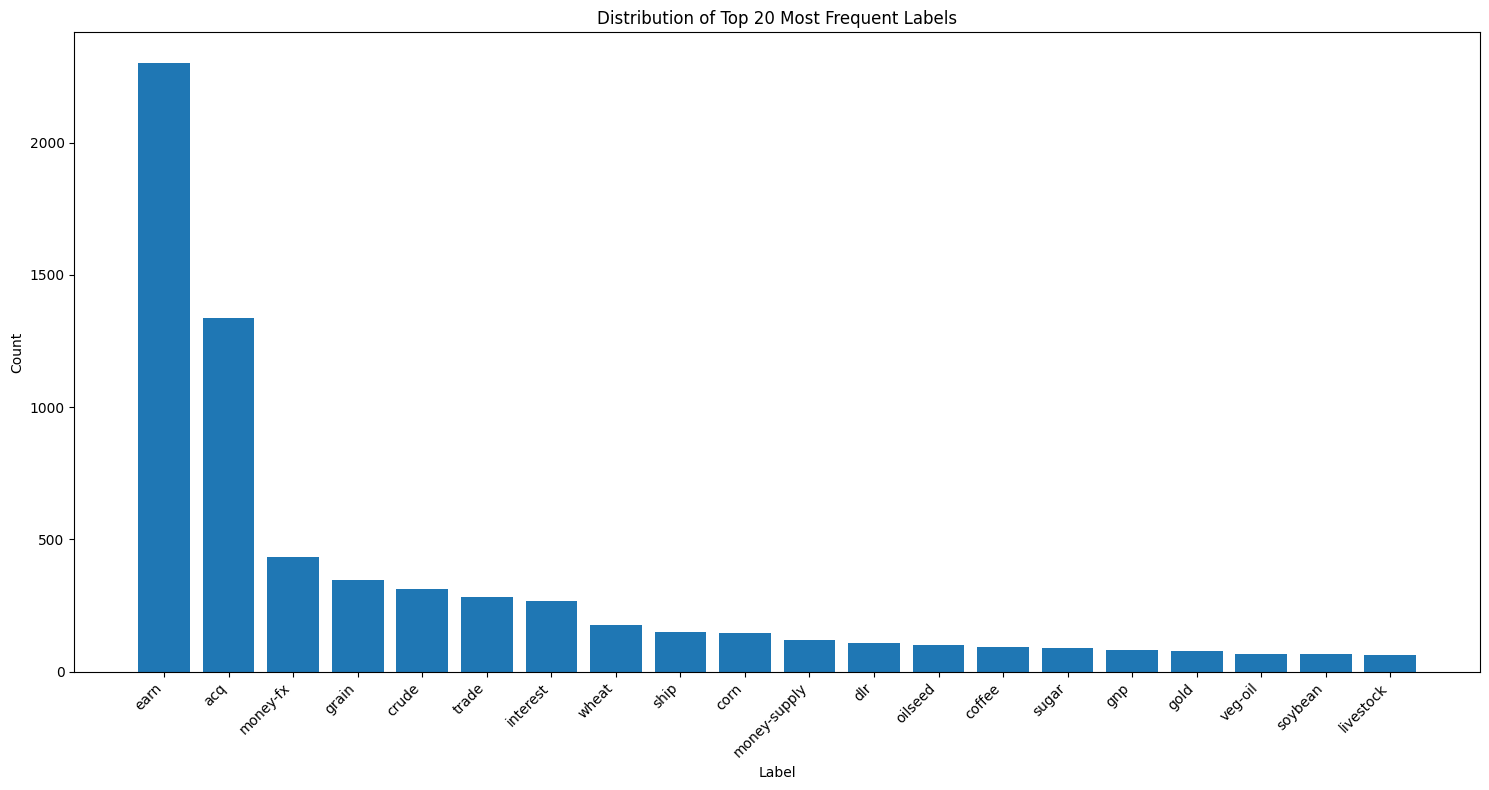

Total number of labels: 90
Average labels per document: 1.23
Most common label: earn (2302.0 occurrences)
Least common label: castor-oil (1.0 occurrences)
Input size (features): 5000
Output size (labels): 90


In [ ]:
def run_experiments(X_train, y_train, X_val, y_val, X_test, y_test, input_size, output_size):
    # Configurations to test
    learning_rates = [0.01, 0.001]
    optimizers = ['mini_batch', 'batch', 'sgd']
    epochs = [20,30]
    hidden_activations = ['sigmoid','relu', 'tanh']
    architectures = [
        [input_size, 128, output_size],
        [input_size, 128, 64, output_size]
    ]
    batch_size=32
    results = []
    for hidden_activation in hidden_activations:
        for optimizer_type in optimizers:
            for learning_rate in learning_rates:
                for architecture in architectures:
                    for epoch in epochs:
                        print(f"\nTraining with: Activation={hidden_activation}, Optimizer={optimizer_type}, "
                              f"LR={learning_rate}, Architecture={architecture}, Batch Size={batch_size}")
                        
                        # Initialize model
                        model = MultiLabelMLP(
                            layer_sizes=architecture,
                            hidden_activation=hidden_activation,
                            optimizer_type=optimizer_type,
                            learning_rate=learning_rate,
                            batch_size=batch_size
                        )
                        
                        start_time = time.time()
                        model.train(X_train, y_train, X_val, y_val, epochs=epoch)
                        training_time = time.time() - start_time
                        
                        # Evaluate on validation set
                        val_predictions = model.predict(X_val)
                        val_metrics = evaluate_model(y_val, val_predictions)
                        
                        # Evaluate on test set
                        test_predictions = model.predict(X_test)
                        test_metrics = evaluate_model(y_test, test_predictions)
                        
                        # Store results
                        experiment_result = {
                            'activation': hidden_activation,
                            'optimizer': optimizer_type,
                            'val_metrics': val_metrics,
                            'test_metrics': test_metrics,
                            'training_time': training_time,
                            'learning_rate': learning_rate,
                            'architecture': architecture,
                            'batch_size': batch_size,
                            'train_loss_history': model.loss_history,
                            'val_loss_history': model.val_loss_history
                        }
                        results.append(experiment_result)
                        
                        # Plot training curves
                        plt.figure(figsize=(10, 5))
                        plt.plot(model.loss_history, label='Training Loss')
                        plt.plot(model.val_loss_history, label='Validation Loss')
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss')
                        plt.title(f'Loss Curves: {hidden_activation} + {optimizer_type} (LR={learning_rate})')
                        plt.legend()
                        plt.grid(True)
                        plt.show()
                        print("--"*20)
                        print("\n")
    
    return results


# Convert data to CuPy arrays
X_train_cp = cp.asarray(X_train)
y_train_cp = cp.asarray(y_train)
X_test_cp = cp.asarray(tf_idf_test)
y_test_cp = cp.asarray(test_labels_matrix)
X_val_cp = cp.asarray(X_val)
y_val_cp = cp.asarray(y_val)

def visualize_label_distribution(y_train):
    label_counts = np.sum(y_train, axis=0)
    sorted_indices = np.argsort(label_counts)[::-1]
    sorted_counts = label_counts[sorted_indices]
    sorted_labels = [label_list[i] for i in sorted_indices]
    
    # Plot top 20 most frequent labels
    plt.figure(figsize=(15, 8))
    plt.bar(range(min(20, len(sorted_labels))), sorted_counts[:20])
    plt.xticks(range(min(20, len(sorted_labels))), sorted_labels[:20], rotation=45, ha='right')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Top 20 Most Frequent Labels')
    plt.tight_layout()
    plt.show()
    
    # Print label statistics
    print(f"Total number of labels: {len(label_list)}")
    print(f"Average labels per document: {np.mean(np.sum(y_train, axis=1)):.2f}")
    print(f"Most common label: {label_list[np.argmax(label_counts)]} ({np.max(label_counts)} occurrences)")
    print(f"Least common label: {label_list[np.argmin(label_counts)]} ({np.min(label_counts)} occurrences)")


# Display label distribution
visualize_label_distribution(y_train_cp.get())  # Convert back to NumPy for visualization

# Get input and output sizes
input_size = X_train_cp.shape[1]
output_size = y_train_cp.shape[1]

print(f"Input size (features): {input_size}")
print(f"Output size (labels): {output_size}")



    


Training with: Activation=relu, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0250, Val Loss: 0.0247
Epoch 20/20, Train Loss: 0.0168, Val Loss: 0.0178


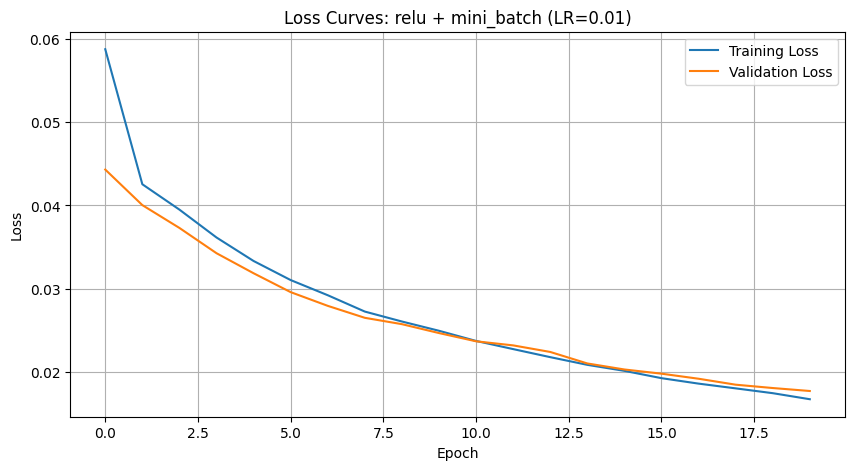

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0253, Val Loss: 0.0251
Epoch 20/30, Train Loss: 0.0169, Val Loss: 0.0177
Epoch 30/30, Train Loss: 0.0127, Val Loss: 0.0151


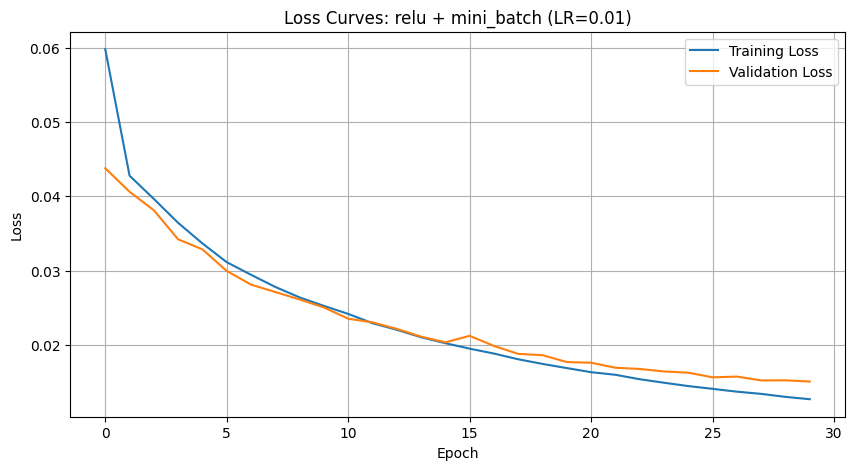

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0221, Val Loss: 0.0266
Epoch 20/20, Train Loss: 0.0126, Val Loss: 0.0136


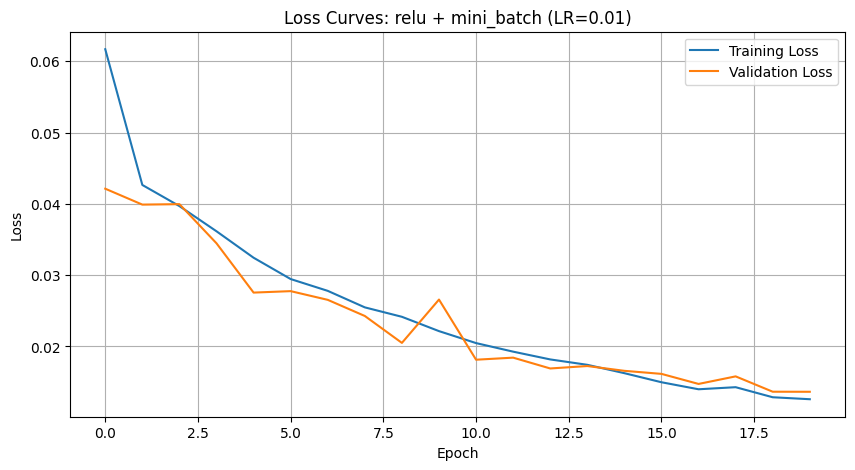

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0240, Val Loss: 0.0256
Epoch 20/30, Train Loss: 0.0135, Val Loss: 0.0134
Epoch 30/30, Train Loss: 0.0187, Val Loss: 0.0252


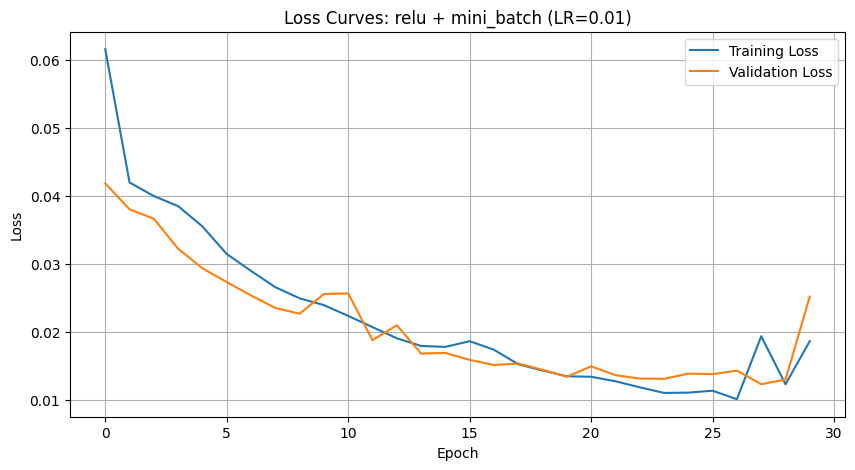

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0429, Val Loss: 0.0426
Epoch 20/20, Train Loss: 0.0395, Val Loss: 0.0394


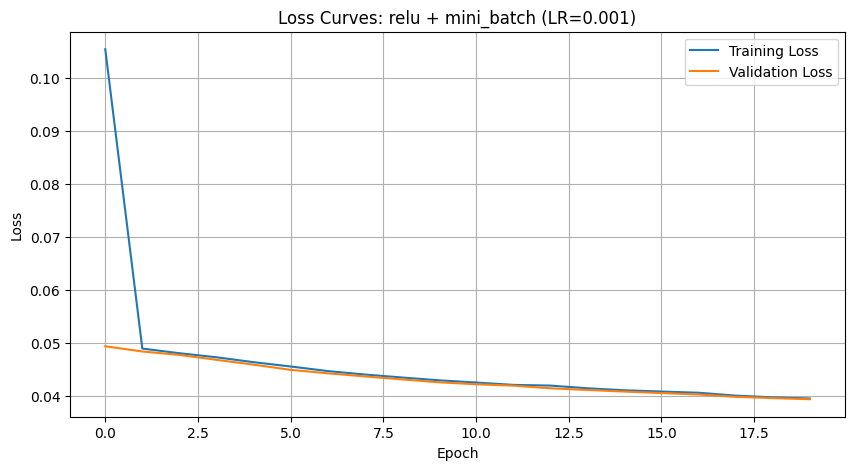

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0430, Val Loss: 0.0427
Epoch 20/30, Train Loss: 0.0395, Val Loss: 0.0393
Epoch 30/30, Train Loss: 0.0358, Val Loss: 0.0357


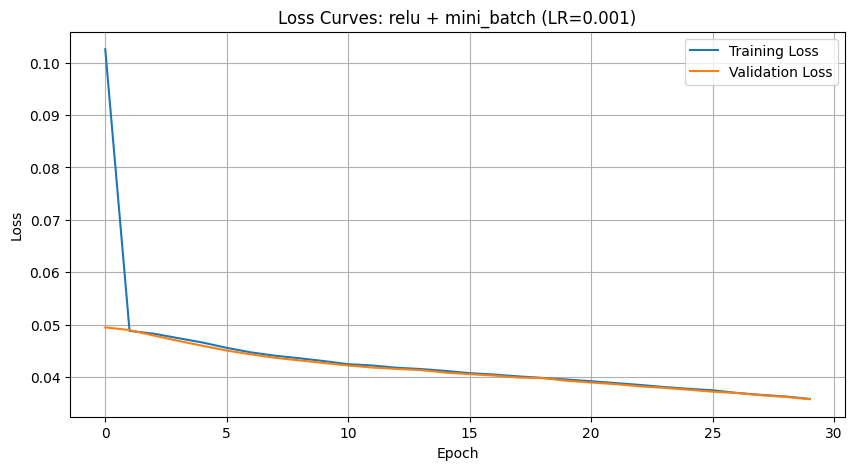

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0388, Val Loss: 0.0387
Epoch 20/20, Train Loss: 0.0303, Val Loss: 0.0304


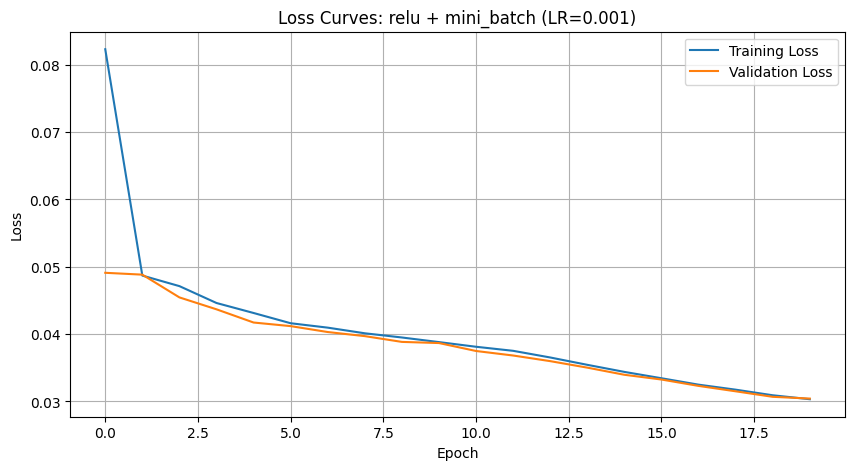

----------------------------------------



Training with: Activation=relu, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0387, Val Loss: 0.0383
Epoch 20/30, Train Loss: 0.0304, Val Loss: 0.0301
Epoch 30/30, Train Loss: 0.0254, Val Loss: 0.0259


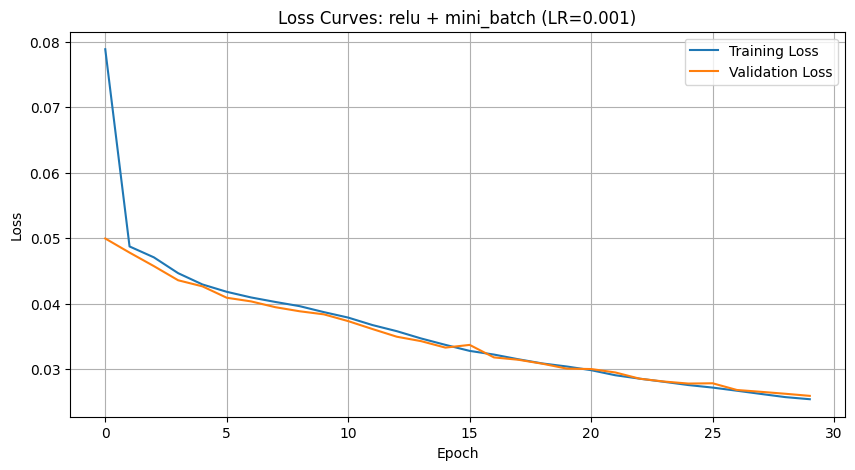

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 20/20, Train Loss: 0.2526, Val Loss: 0.2520


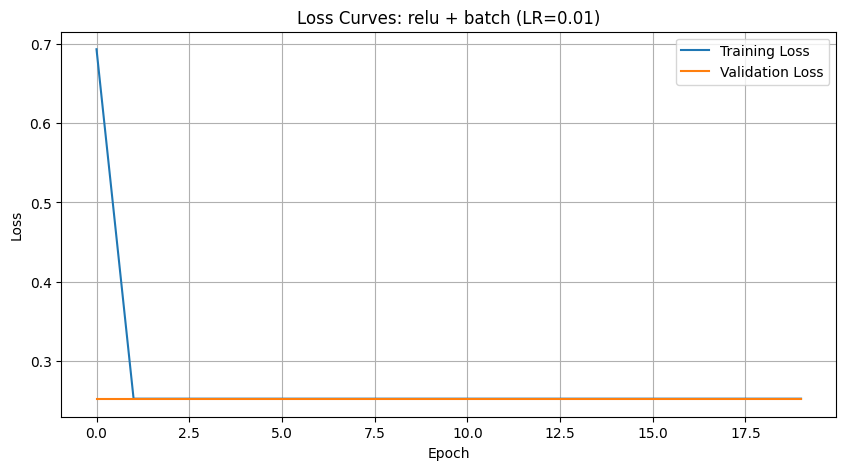

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 20/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 30/30, Train Loss: 0.2526, Val Loss: 0.2520


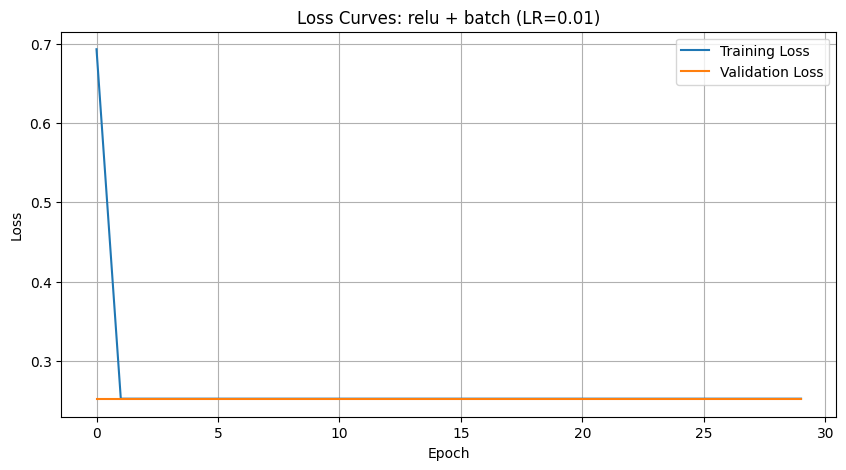

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.3057, Val Loss: 0.3052
Epoch 20/20, Train Loss: 0.3057, Val Loss: 0.3052


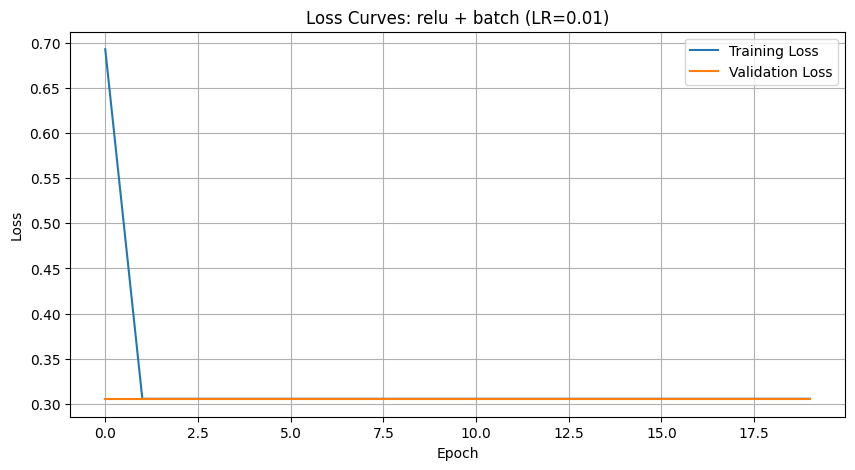

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 20/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 30/30, Train Loss: 0.2526, Val Loss: 0.2520


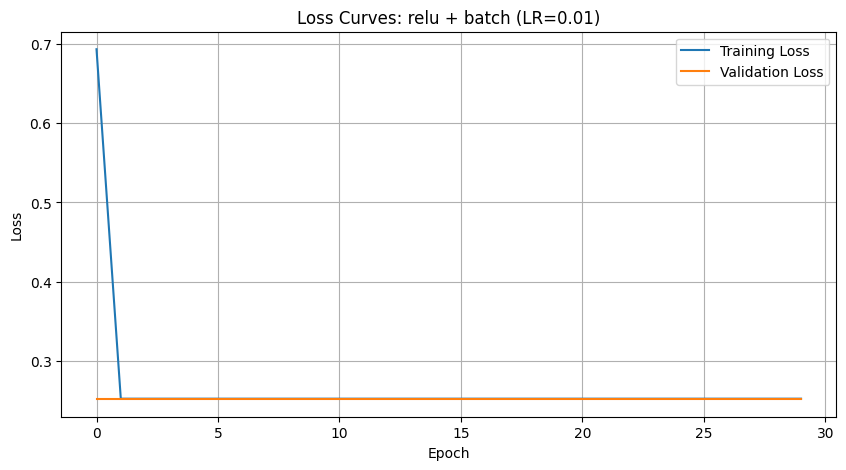

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0633, Val Loss: 0.0634
Epoch 20/20, Train Loss: 0.0565, Val Loss: 0.0562


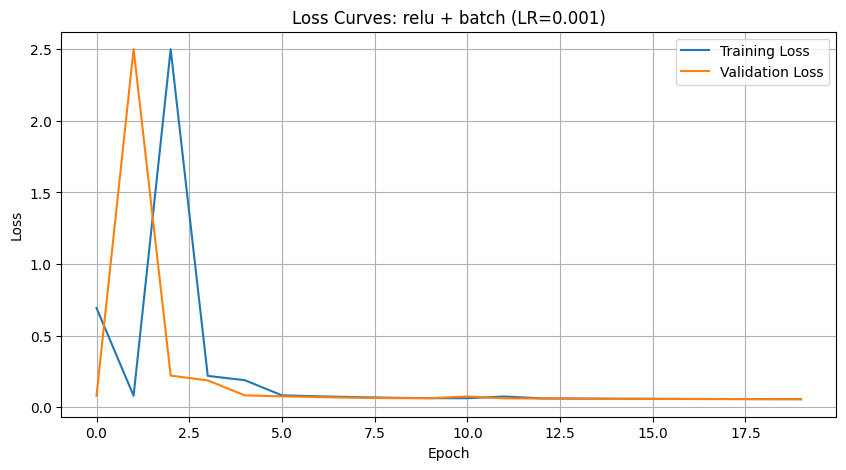

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0684, Val Loss: 0.0668
Epoch 20/30, Train Loss: 0.0559, Val Loss: 0.0557
Epoch 30/30, Train Loss: 0.0532, Val Loss: 0.0532


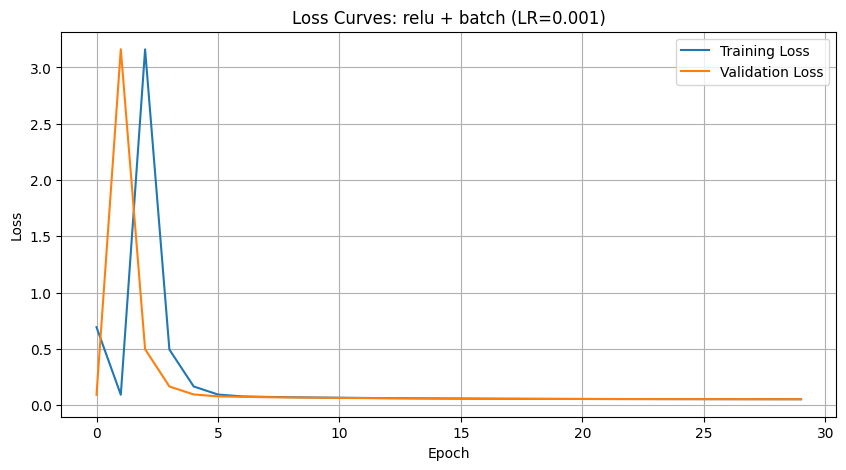

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0720, Val Loss: 0.0680
Epoch 20/20, Train Loss: 0.0543, Val Loss: 0.0527


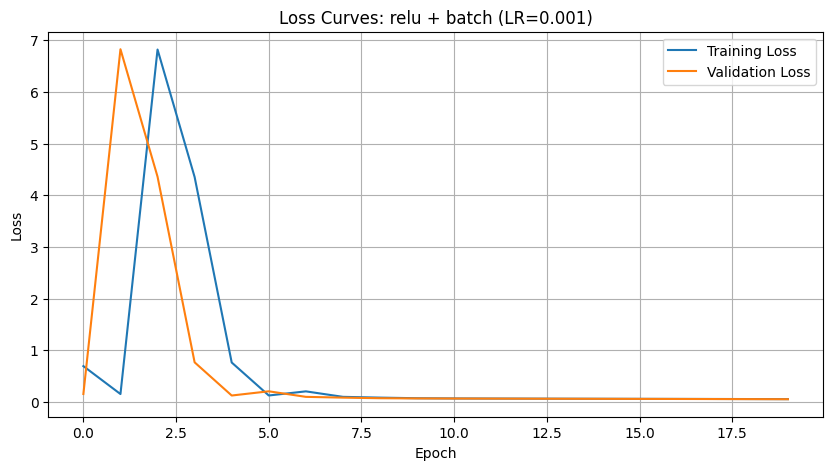

----------------------------------------



Training with: Activation=relu, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0616, Val Loss: 0.0606
Epoch 20/30, Train Loss: 0.0558, Val Loss: 0.0556
Epoch 30/30, Train Loss: 0.0532, Val Loss: 0.0533


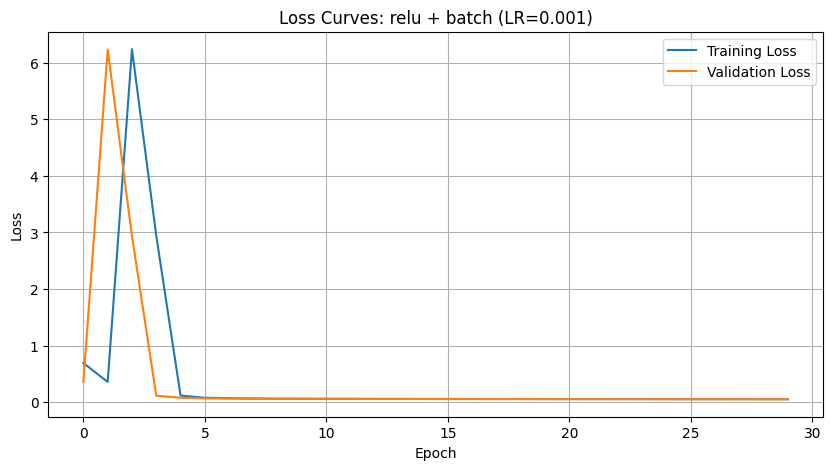

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0242, Val Loss: 0.0244
Epoch 20/20, Train Loss: 0.0164, Val Loss: 0.0182


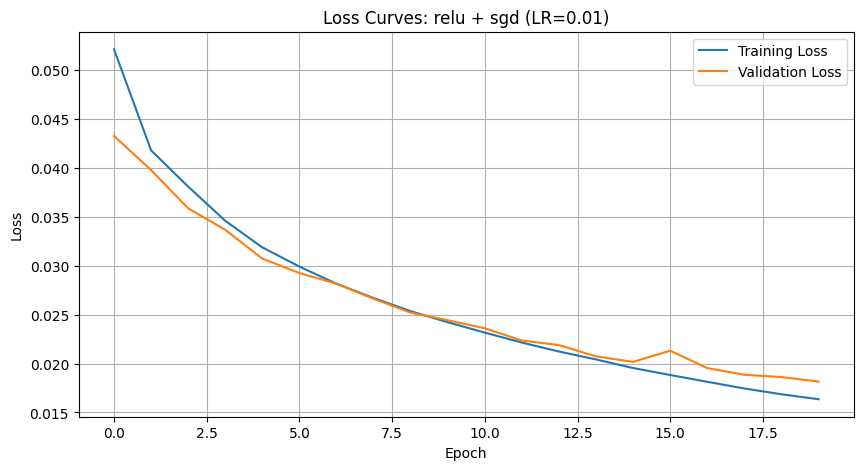

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0244, Val Loss: 0.0243
Epoch 20/30, Train Loss: 0.0163, Val Loss: 0.0176
Epoch 30/30, Train Loss: 0.0122, Val Loss: 0.0147


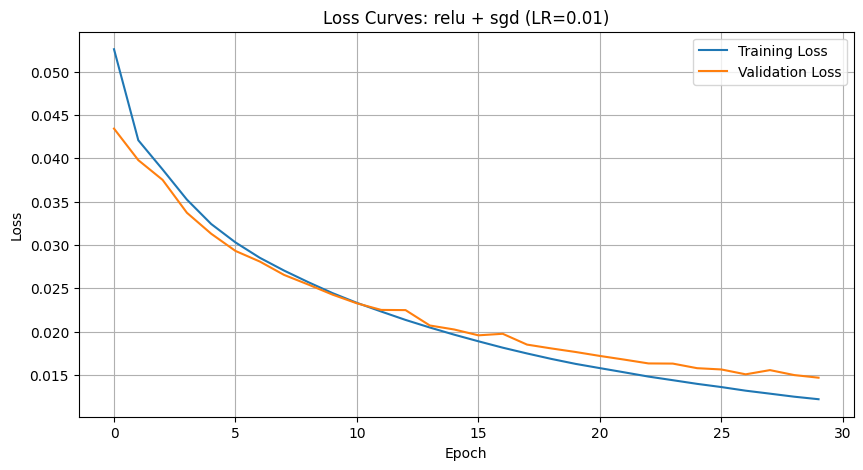

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0150, Val Loss: 0.0166
Epoch 20/20, Train Loss: 0.0082, Val Loss: 0.0136


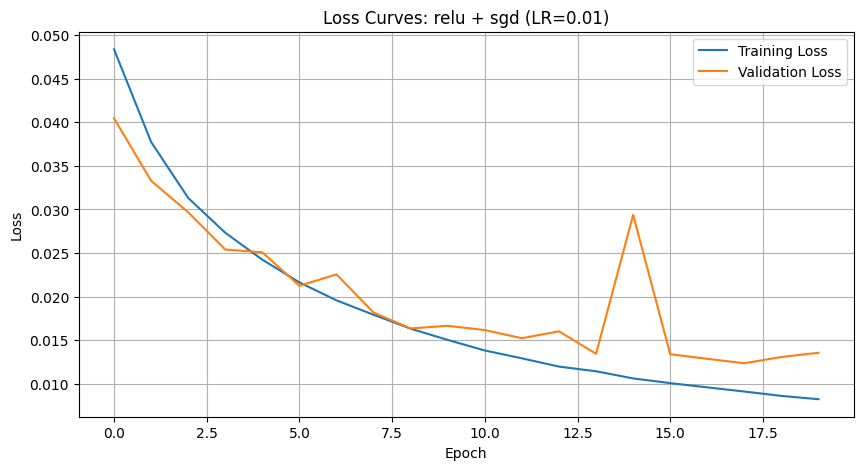

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0148, Val Loss: 0.0155
Epoch 20/30, Train Loss: 0.0079, Val Loss: 0.0126
Epoch 30/30, Train Loss: 0.0051, Val Loss: 0.0120


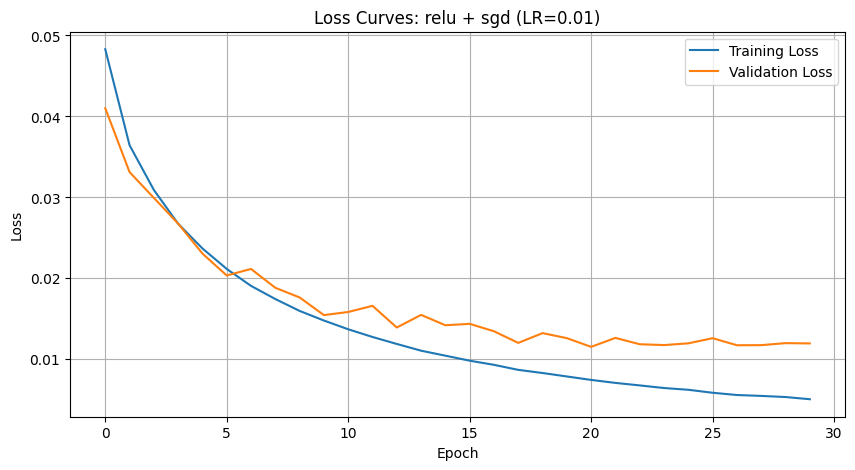

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0432, Val Loss: 0.0428
Epoch 20/20, Train Loss: 0.0395, Val Loss: 0.0393


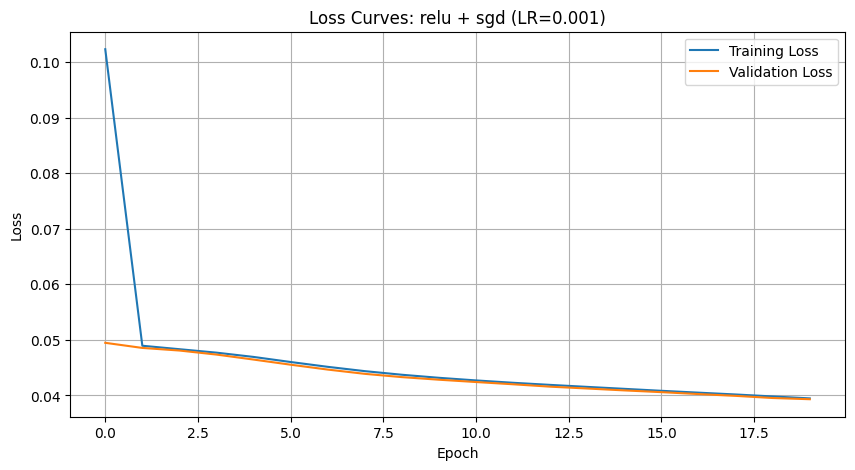

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0429, Val Loss: 0.0426
Epoch 20/30, Train Loss: 0.0394, Val Loss: 0.0392
Epoch 30/30, Train Loss: 0.0357, Val Loss: 0.0355


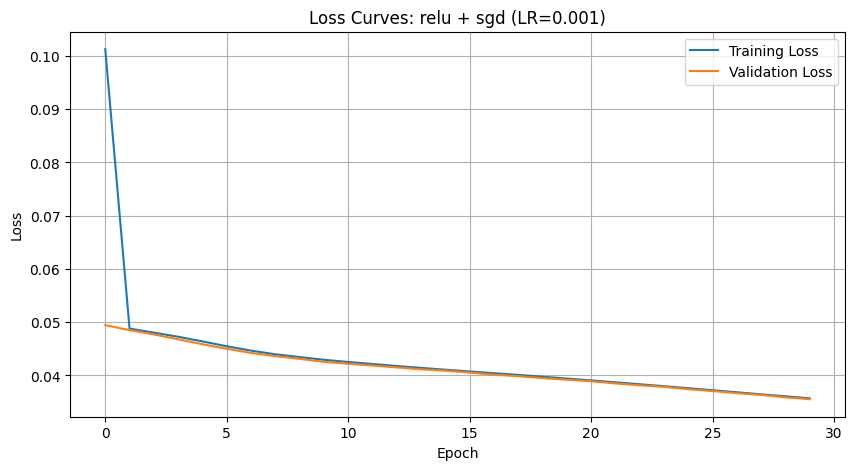

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0389, Val Loss: 0.0384
Epoch 20/20, Train Loss: 0.0300, Val Loss: 0.0304


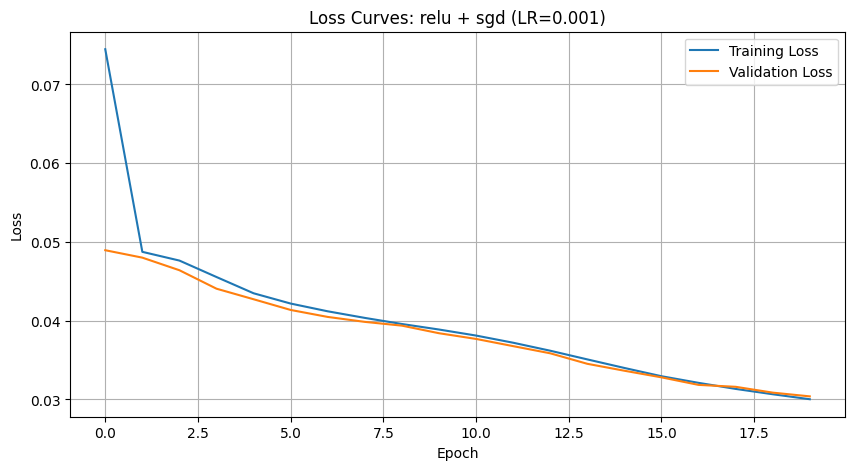

----------------------------------------



Training with: Activation=relu, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0380, Val Loss: 0.0377
Epoch 20/30, Train Loss: 0.0291, Val Loss: 0.0292
Epoch 30/30, Train Loss: 0.0247, Val Loss: 0.0258


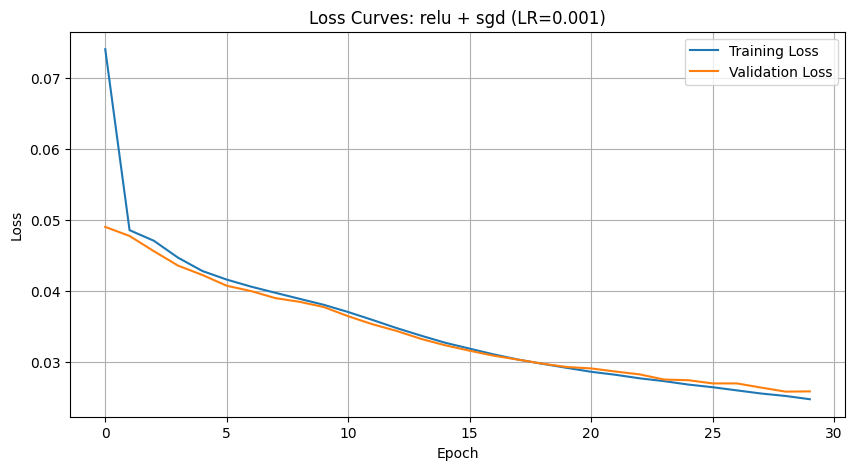

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0251, Val Loss: 0.0252
Epoch 20/20, Train Loss: 0.0168, Val Loss: 0.0182


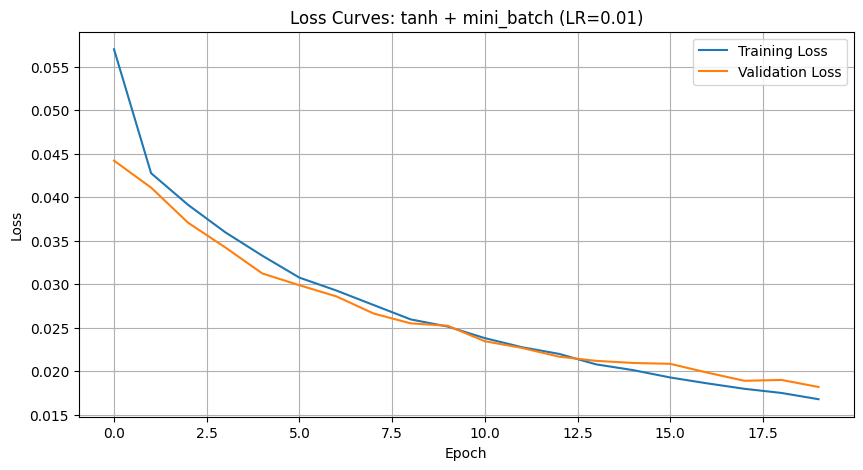

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0250, Val Loss: 0.0263
Epoch 20/30, Train Loss: 0.0167, Val Loss: 0.0178
Epoch 30/30, Train Loss: 0.0125, Val Loss: 0.0152


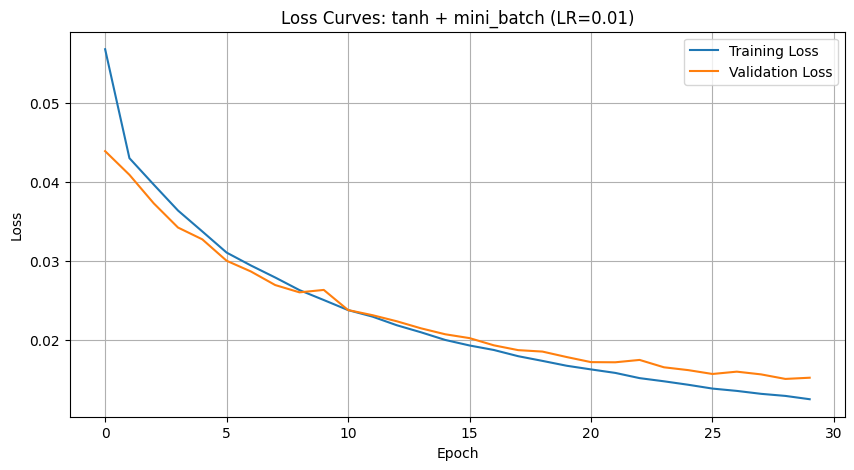

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0180, Val Loss: 0.0169
Epoch 20/20, Train Loss: 0.0106, Val Loss: 0.0120


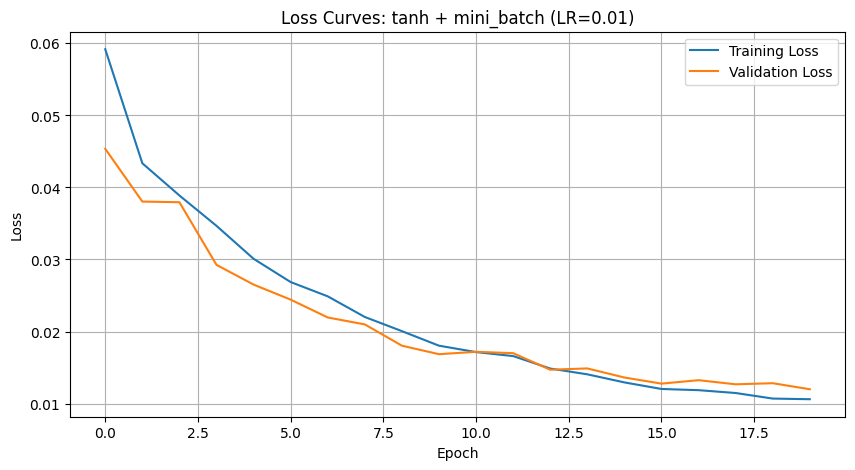

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0183, Val Loss: 0.0176
Epoch 20/30, Train Loss: 0.0103, Val Loss: 0.0141
Epoch 30/30, Train Loss: 0.0067, Val Loss: 0.0107


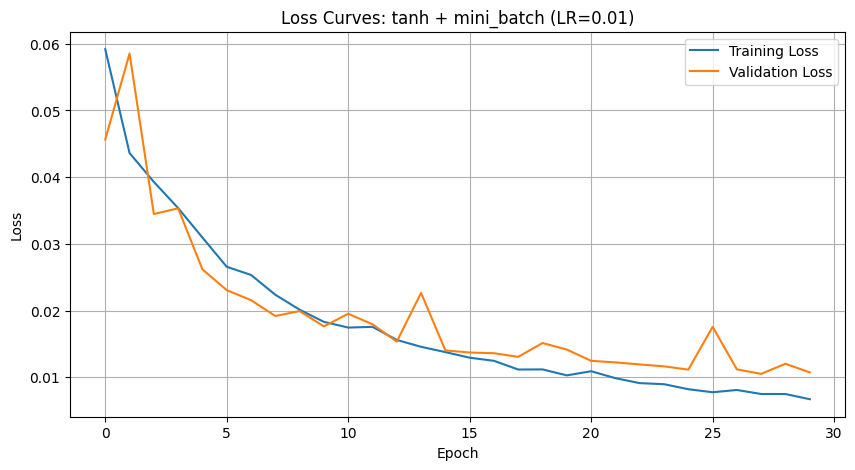

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0434, Val Loss: 0.0432
Epoch 20/20, Train Loss: 0.0400, Val Loss: 0.0398


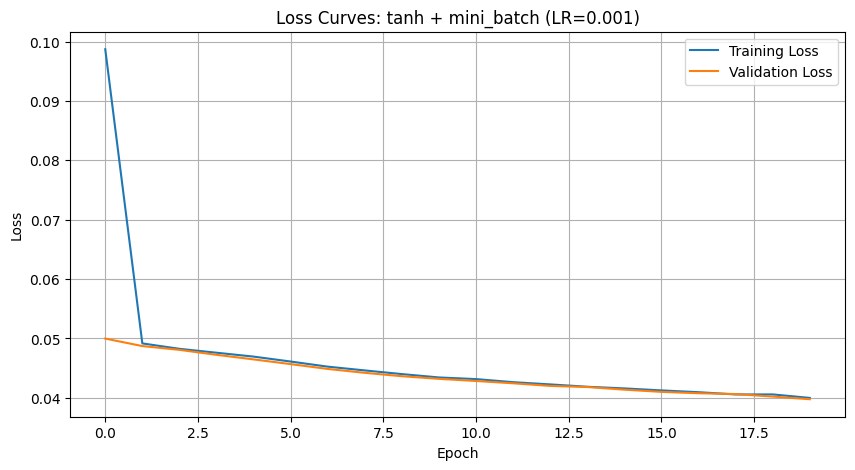

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0437, Val Loss: 0.0433
Epoch 20/30, Train Loss: 0.0401, Val Loss: 0.0399
Epoch 30/30, Train Loss: 0.0367, Val Loss: 0.0366


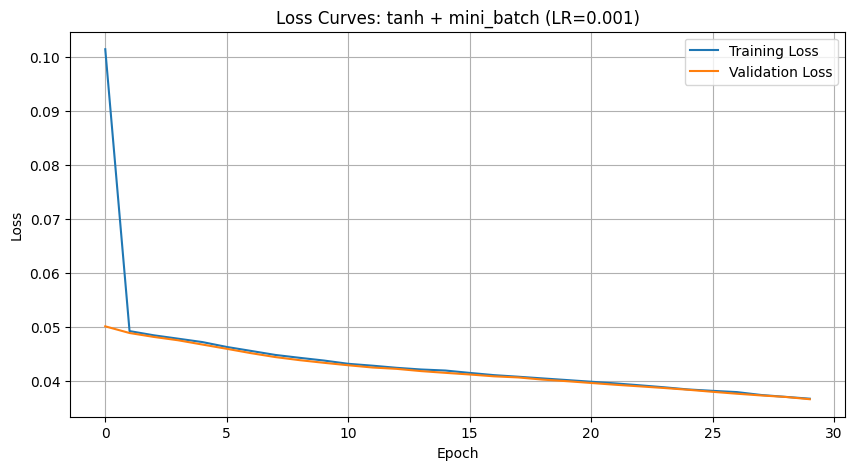

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0411, Val Loss: 0.0406
Epoch 20/20, Train Loss: 0.0340, Val Loss: 0.0336


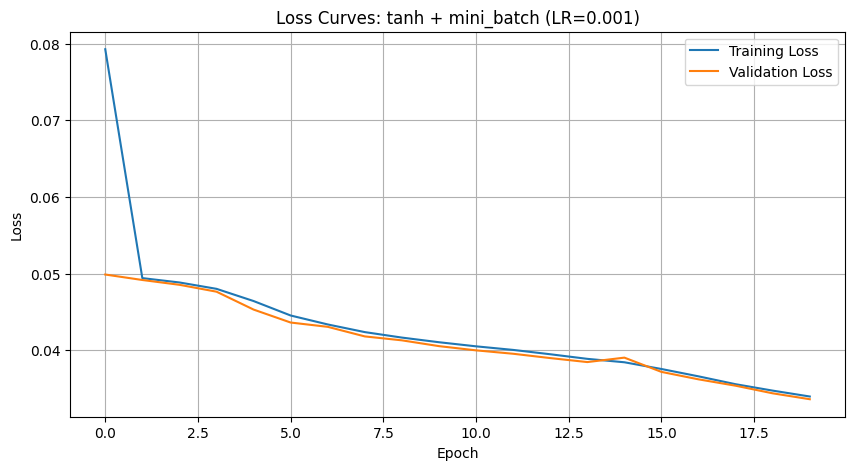

----------------------------------------



Training with: Activation=tanh, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0412, Val Loss: 0.0409
Epoch 20/30, Train Loss: 0.0351, Val Loss: 0.0348
Epoch 30/30, Train Loss: 0.0294, Val Loss: 0.0297


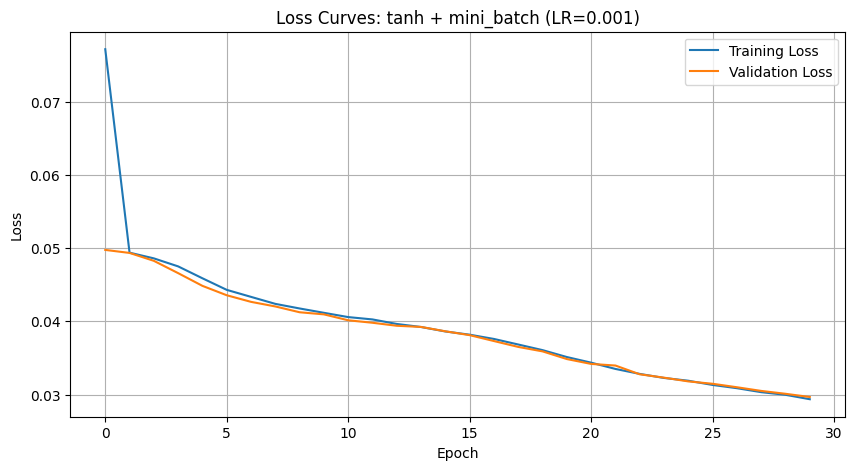

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 20/20, Train Loss: 0.5984, Val Loss: 0.6044


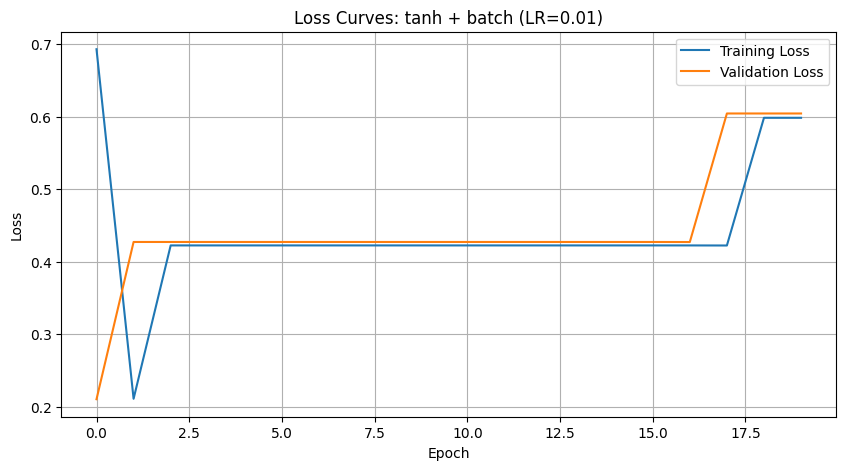

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 20/30, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 30/30, Train Loss: 0.6094, Val Loss: 0.6110


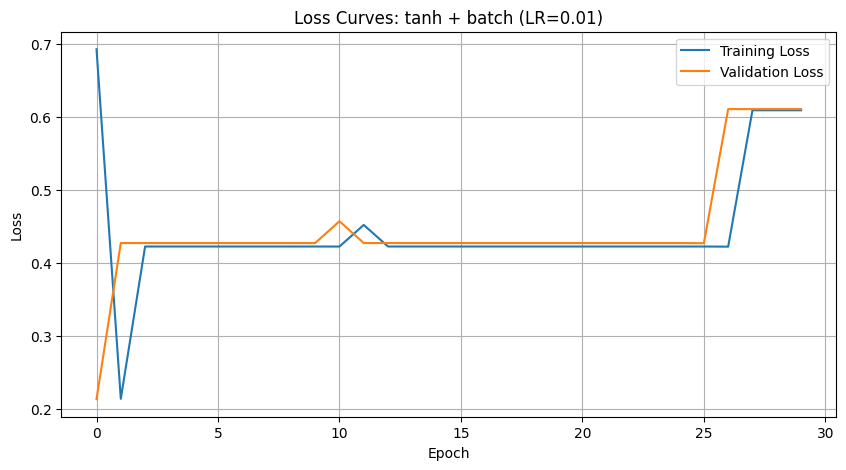

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 20/20, Train Loss: 0.5761, Val Loss: 0.4271


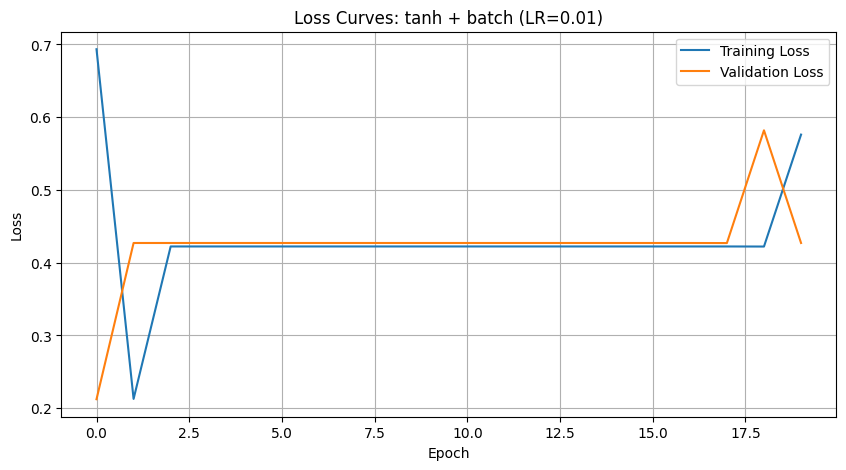

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 20/30, Train Loss: 0.4224, Val Loss: 0.4271
Epoch 30/30, Train Loss: 0.4224, Val Loss: 0.4271


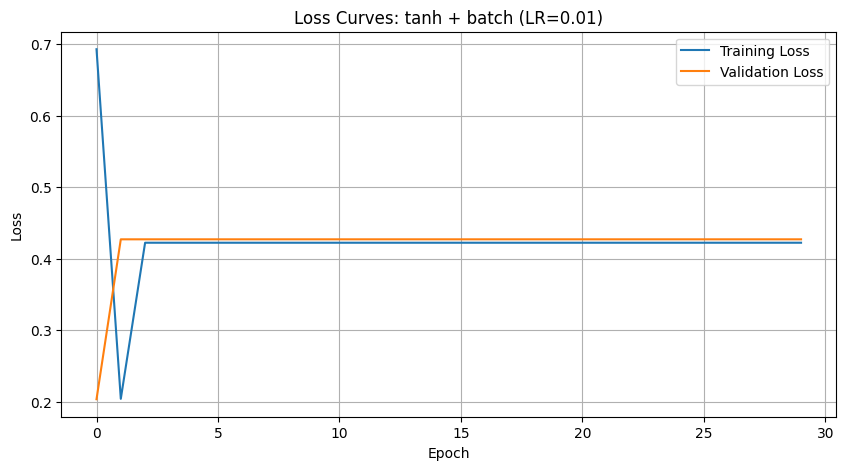

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.4451, Val Loss: 0.4168
Epoch 20/20, Train Loss: 0.4091, Val Loss: 0.4138


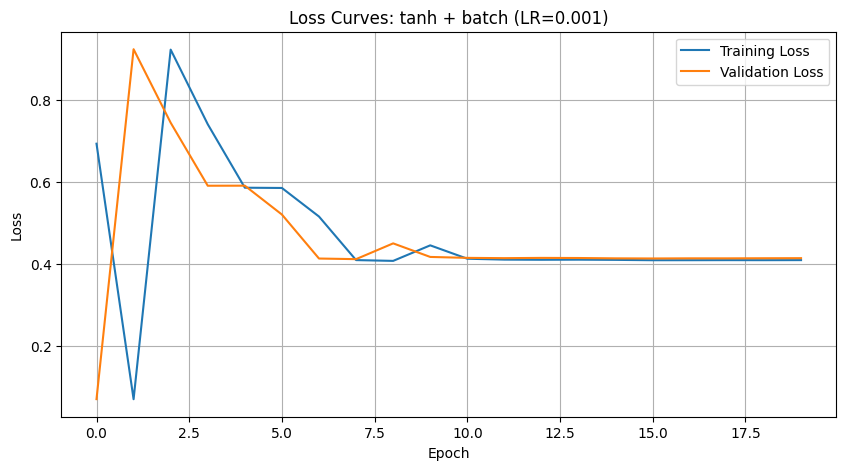

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.4078, Val Loss: 0.4121
Epoch 20/30, Train Loss: 0.4092, Val Loss: 0.4131
Epoch 30/30, Train Loss: 0.4093, Val Loss: 0.4143


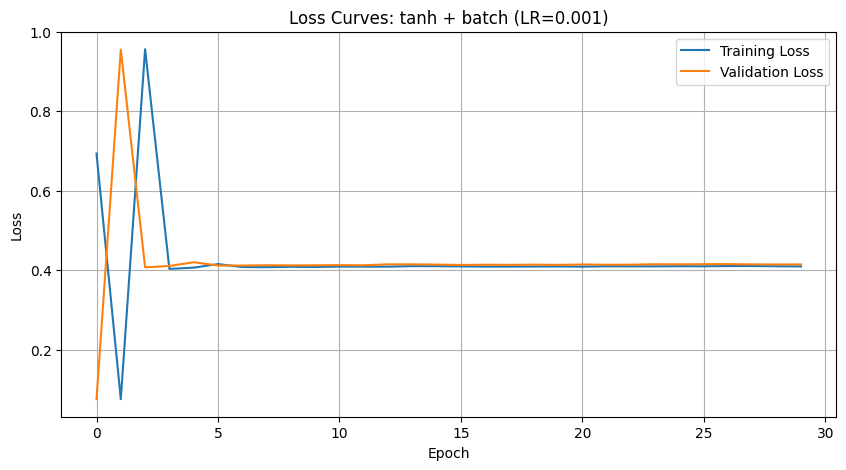

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.4006, Val Loss: 0.4062
Epoch 20/20, Train Loss: 0.4021, Val Loss: 0.4062


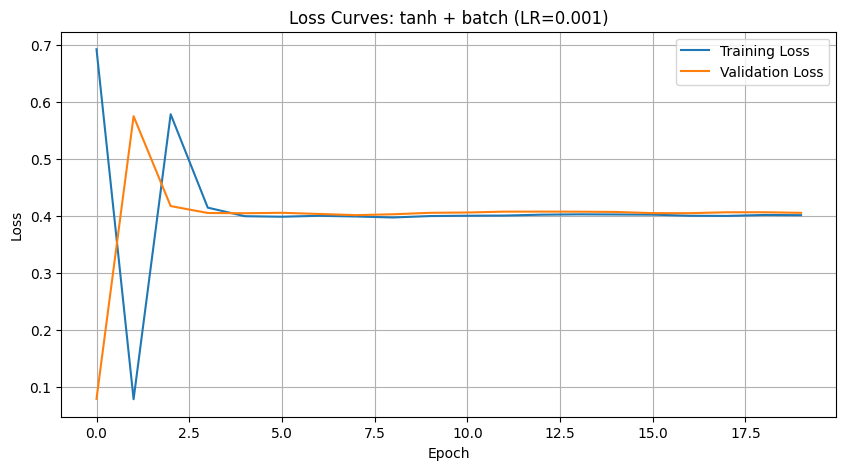

----------------------------------------



Training with: Activation=tanh, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.3498, Val Loss: 0.3539
Epoch 20/30, Train Loss: 0.3484, Val Loss: 0.3537
Epoch 30/30, Train Loss: 0.3490, Val Loss: 0.3525


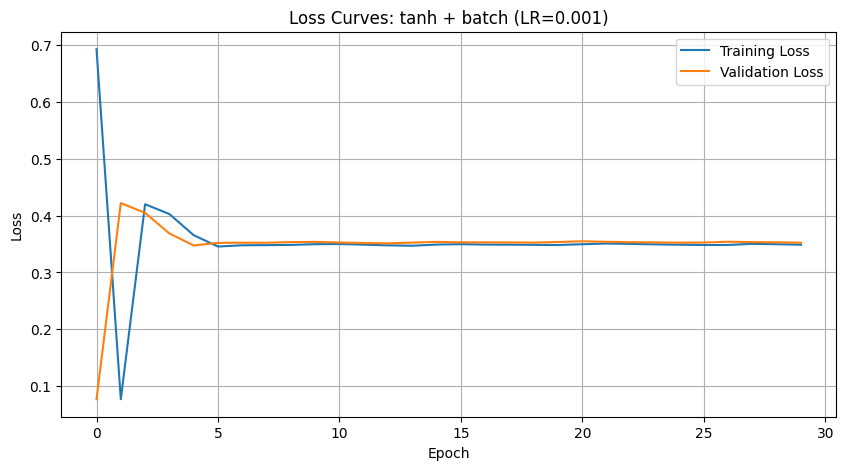

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0246, Val Loss: 0.0243
Epoch 20/20, Train Loss: 0.0166, Val Loss: 0.0178


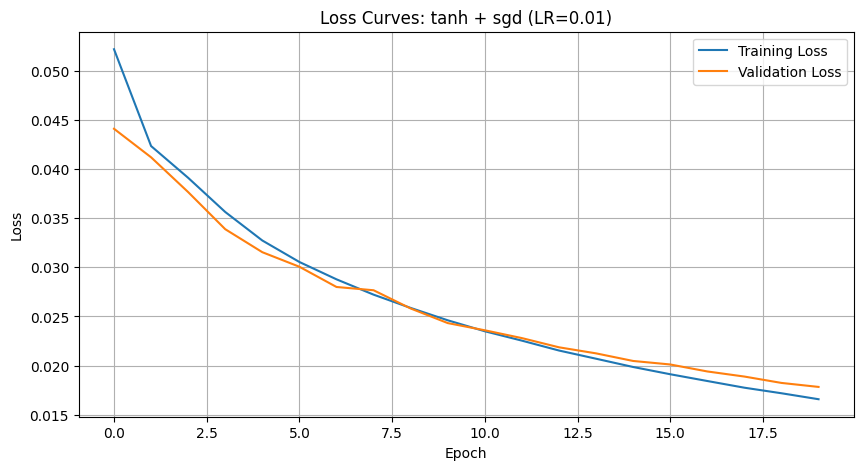

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0247, Val Loss: 0.0246
Epoch 20/30, Train Loss: 0.0166, Val Loss: 0.0176
Epoch 30/30, Train Loss: 0.0124, Val Loss: 0.0149


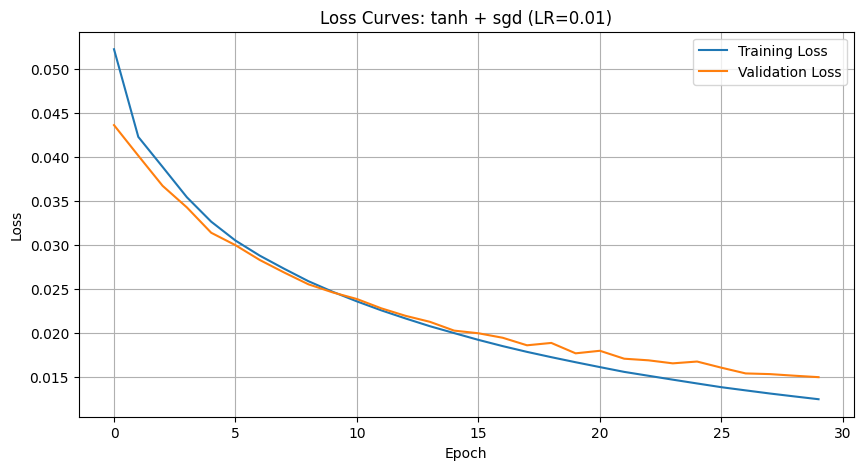

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0155, Val Loss: 0.0170
Epoch 20/20, Train Loss: 0.0086, Val Loss: 0.0124


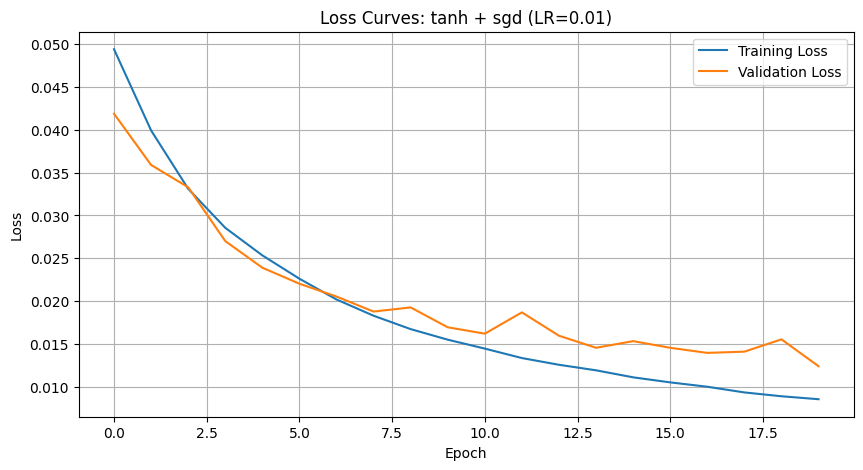

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0163, Val Loss: 0.0182
Epoch 20/30, Train Loss: 0.0088, Val Loss: 0.0147
Epoch 30/30, Train Loss: 0.0056, Val Loss: 0.0129


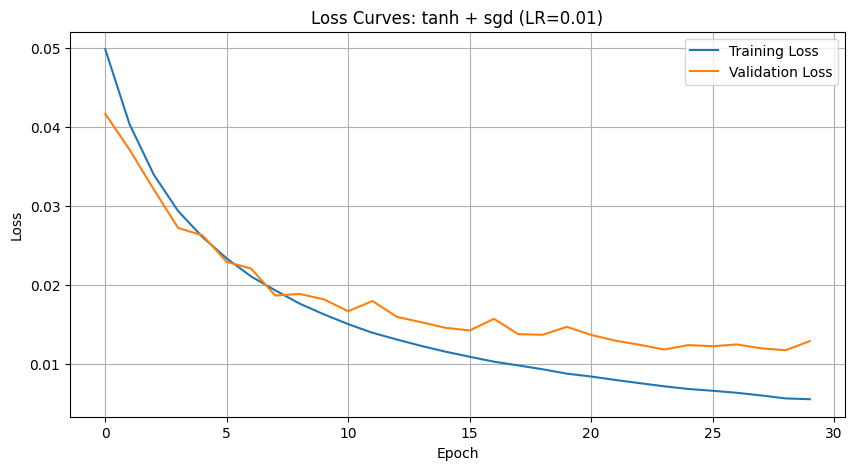

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0434, Val Loss: 0.0430
Epoch 20/20, Train Loss: 0.0400, Val Loss: 0.0398


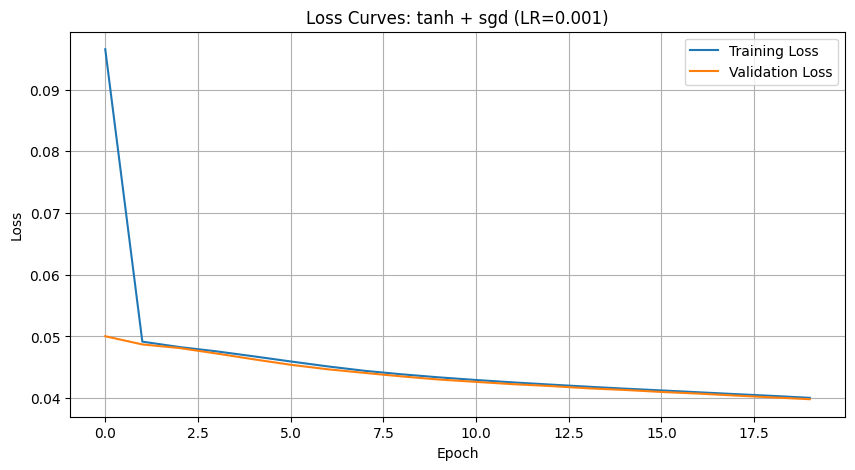

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0437, Val Loss: 0.0434
Epoch 20/30, Train Loss: 0.0402, Val Loss: 0.0401
Epoch 30/30, Train Loss: 0.0368, Val Loss: 0.0367


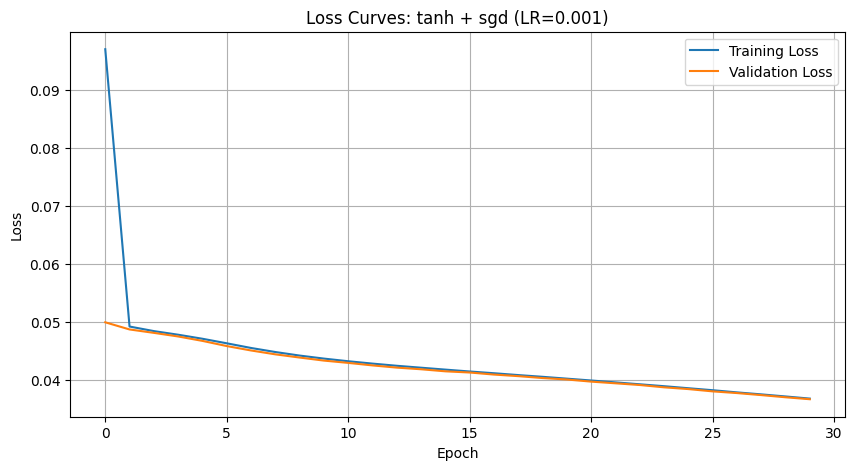

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0412, Val Loss: 0.0408
Epoch 20/20, Train Loss: 0.0365, Val Loss: 0.0363


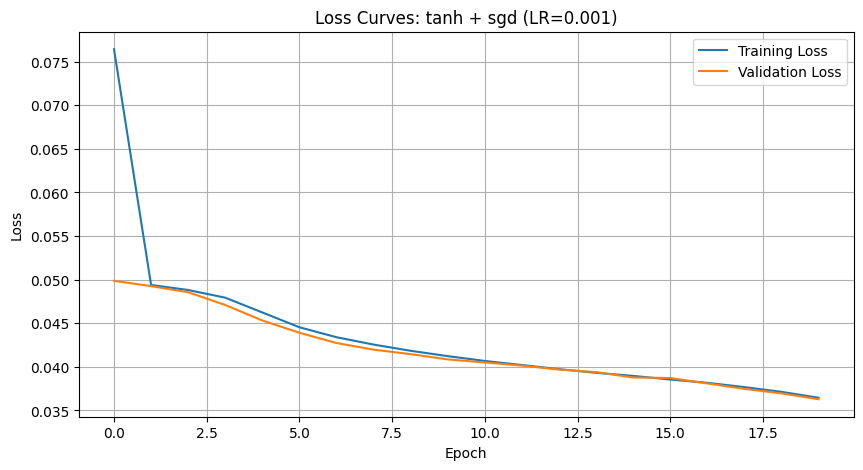

----------------------------------------



Training with: Activation=tanh, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0412, Val Loss: 0.0410
Epoch 20/30, Train Loss: 0.0369, Val Loss: 0.0368
Epoch 30/30, Train Loss: 0.0298, Val Loss: 0.0304


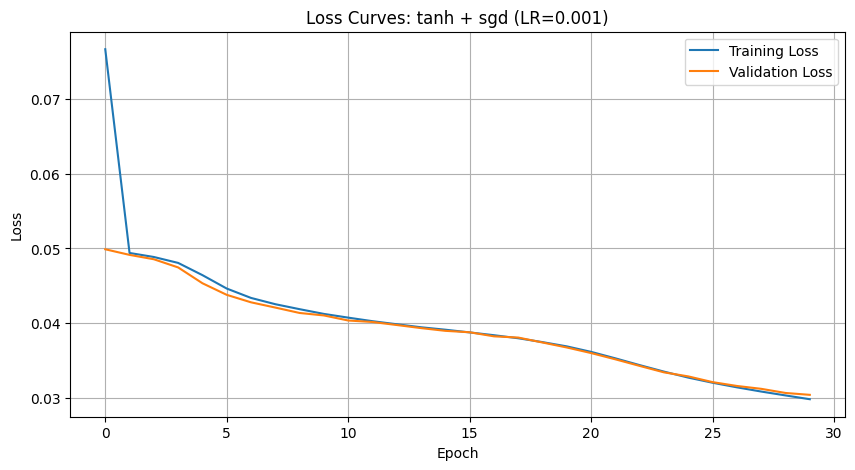

----------------------------------------



Training with: Activation=sigmoid, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0410, Val Loss: 0.0404
Epoch 20/20, Train Loss: 0.0337, Val Loss: 0.0335


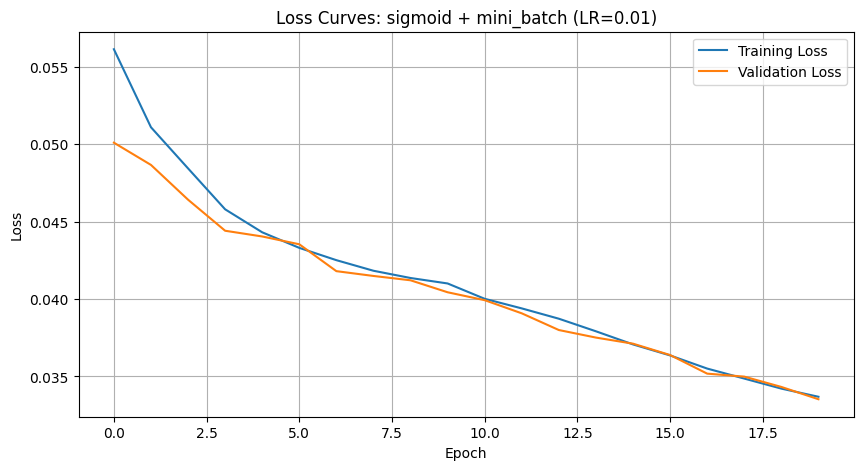

----------------------------------------



Training with: Activation=sigmoid, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0408, Val Loss: 0.0408
Epoch 20/30, Train Loss: 0.0338, Val Loss: 0.0334
Epoch 30/30, Train Loss: 0.0297, Val Loss: 0.0294


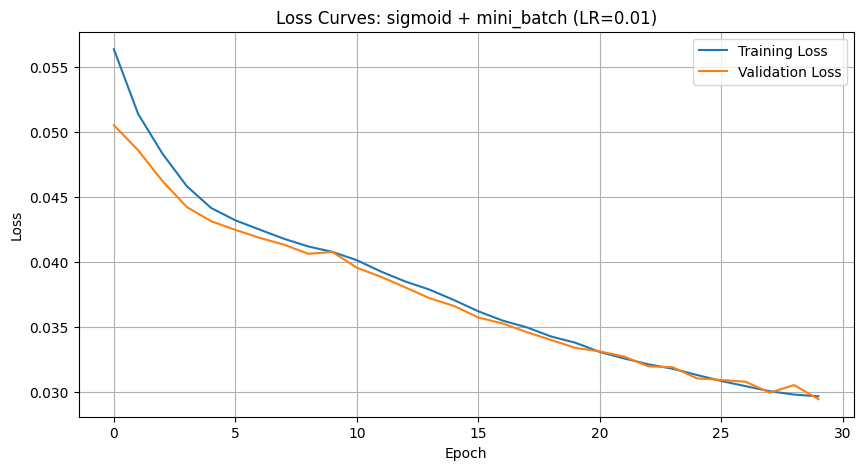

----------------------------------------



Training with: Activation=sigmoid, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0485, Val Loss: 0.0462
Epoch 20/20, Train Loss: 0.0383, Val Loss: 0.0374


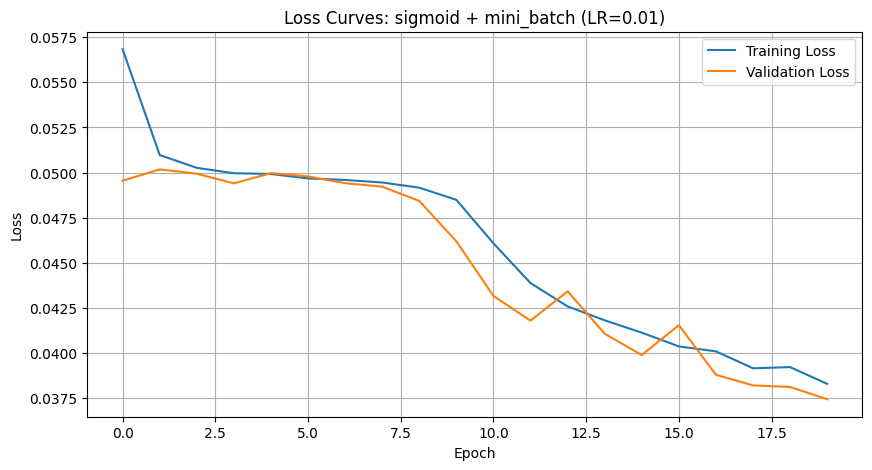

----------------------------------------



Training with: Activation=sigmoid, Optimizer=mini_batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0485, Val Loss: 0.0465
Epoch 20/30, Train Loss: 0.0386, Val Loss: 0.0376
Epoch 30/30, Train Loss: 0.0336, Val Loss: 0.0334


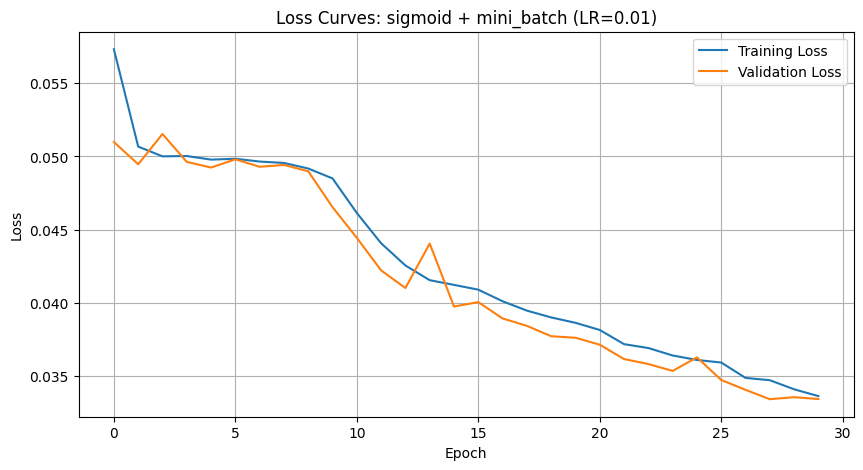

----------------------------------------



Training with: Activation=sigmoid, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0487, Val Loss: 0.0487
Epoch 20/20, Train Loss: 0.0476, Val Loss: 0.0475


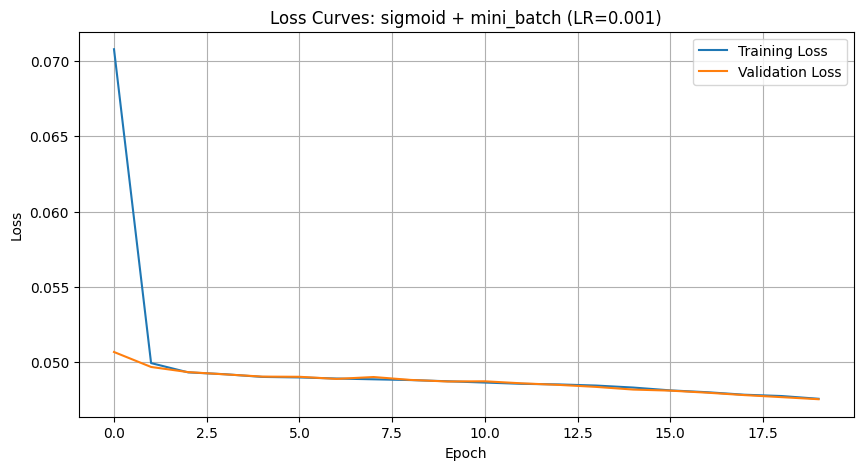

----------------------------------------



Training with: Activation=sigmoid, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0487, Val Loss: 0.0488
Epoch 20/30, Train Loss: 0.0478, Val Loss: 0.0476
Epoch 30/30, Train Loss: 0.0456, Val Loss: 0.0456


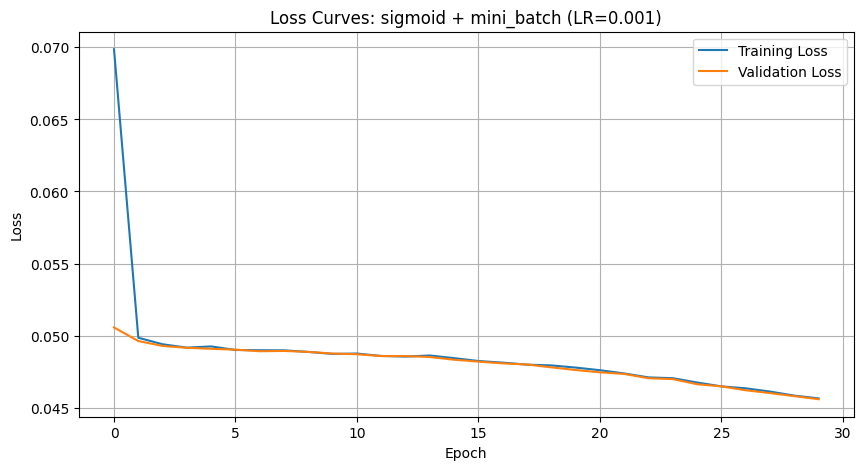

----------------------------------------



Training with: Activation=sigmoid, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0491, Val Loss: 0.0491
Epoch 20/20, Train Loss: 0.0490, Val Loss: 0.0491


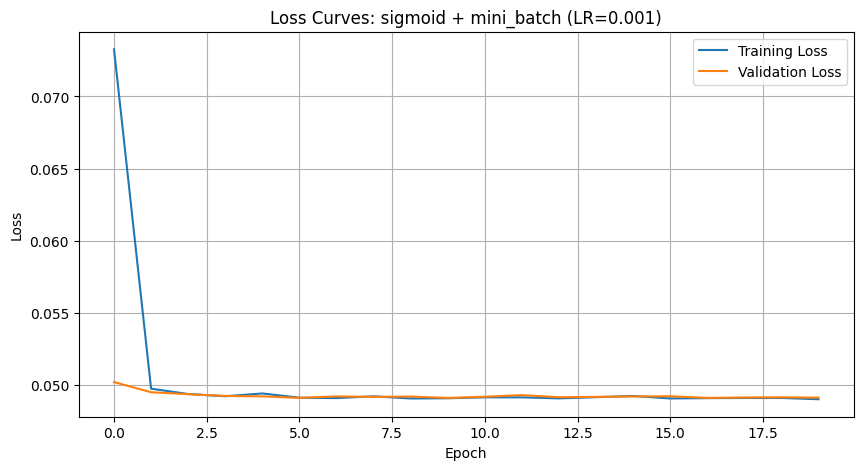

----------------------------------------



Training with: Activation=sigmoid, Optimizer=mini_batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0493, Val Loss: 0.0493
Epoch 20/30, Train Loss: 0.0491, Val Loss: 0.0492
Epoch 30/30, Train Loss: 0.0490, Val Loss: 0.0492


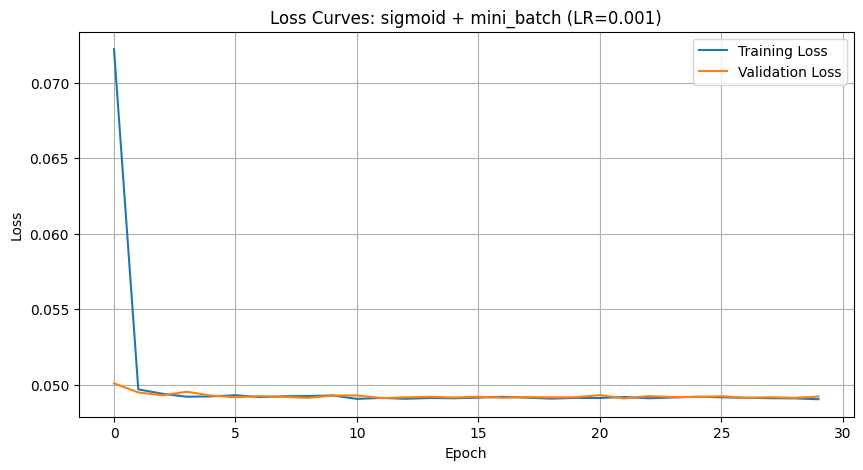

----------------------------------------



Training with: Activation=sigmoid, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.3057, Val Loss: 0.3052
Epoch 20/20, Train Loss: 0.3057, Val Loss: 0.3052


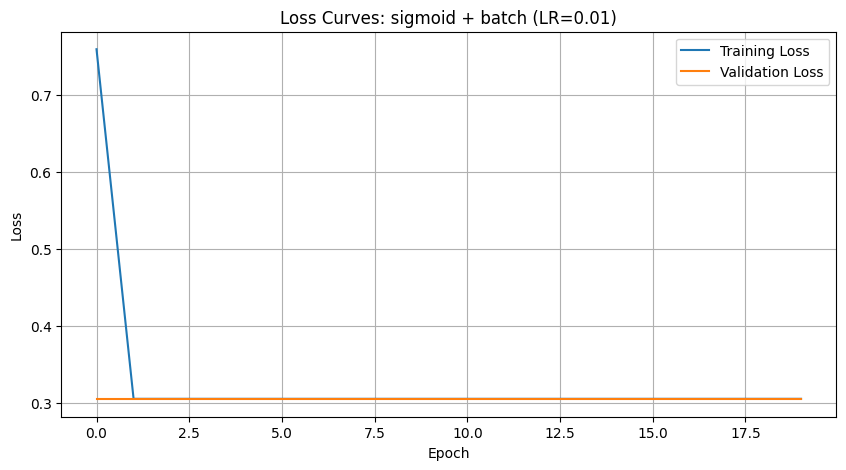

----------------------------------------



Training with: Activation=sigmoid, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 20/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 30/30, Train Loss: 0.2526, Val Loss: 0.2520


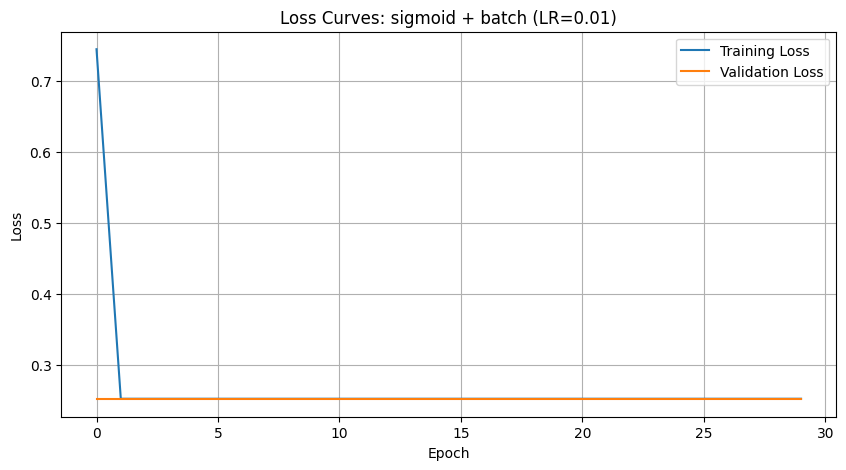

----------------------------------------



Training with: Activation=sigmoid, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 20/20, Train Loss: 0.2526, Val Loss: 0.2520


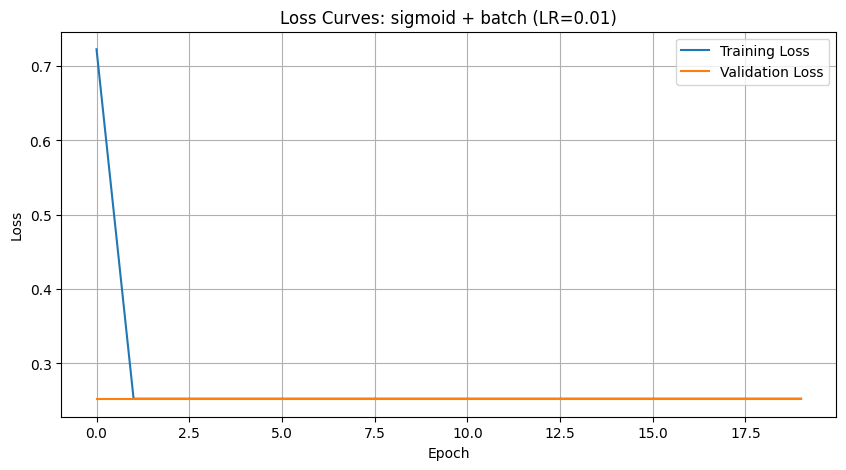

----------------------------------------



Training with: Activation=sigmoid, Optimizer=batch, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 20/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 30/30, Train Loss: 0.2526, Val Loss: 0.2520


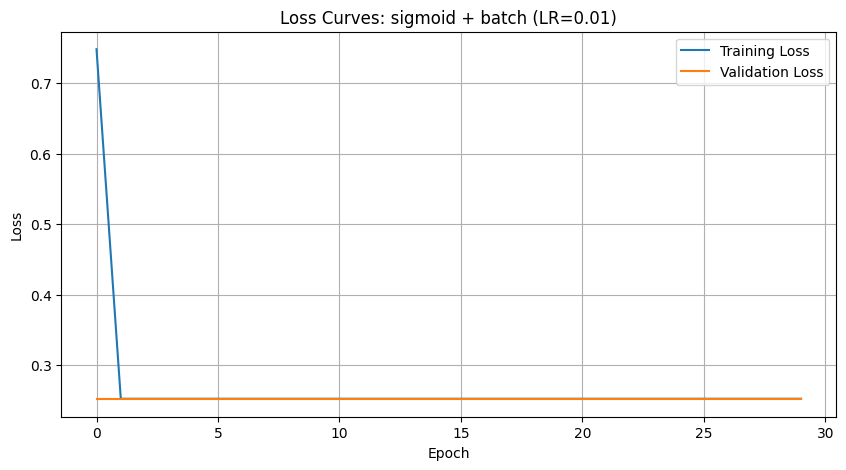

----------------------------------------



Training with: Activation=sigmoid, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.3057, Val Loss: 0.3052
Epoch 20/20, Train Loss: 0.3057, Val Loss: 0.3052


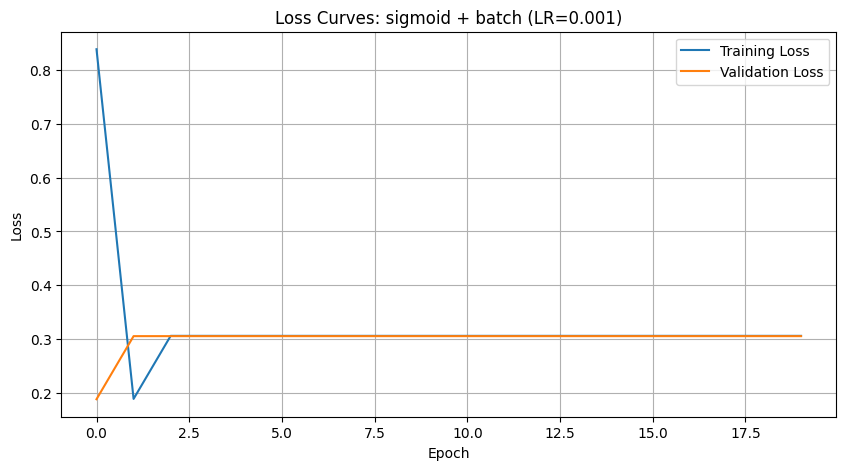

----------------------------------------



Training with: Activation=sigmoid, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 20/30, Train Loss: 0.2526, Val Loss: 0.2520
Epoch 30/30, Train Loss: 0.2526, Val Loss: 0.2520


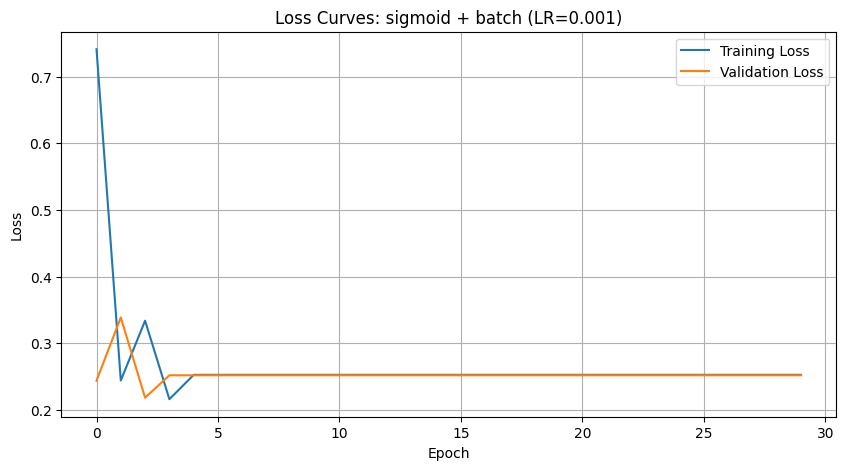

----------------------------------------



Training with: Activation=sigmoid, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.3041, Val Loss: 0.3037
Epoch 20/20, Train Loss: 0.3041, Val Loss: 0.3036


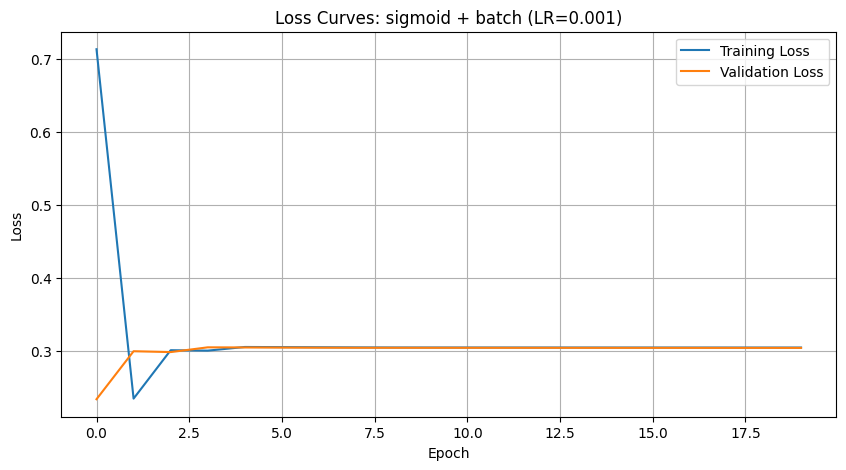

----------------------------------------



Training with: Activation=sigmoid, Optimizer=batch, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.2492, Val Loss: 0.2474
Epoch 20/30, Train Loss: 0.2489, Val Loss: 0.2478
Epoch 30/30, Train Loss: 0.2511, Val Loss: 0.2488


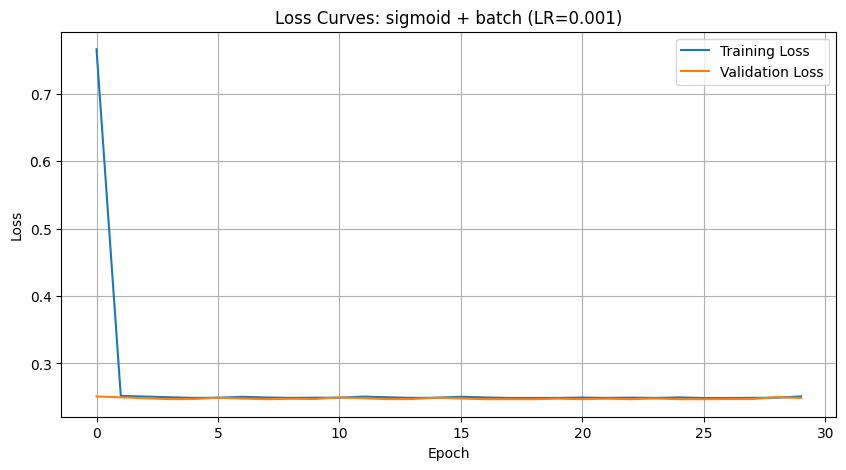

----------------------------------------



Training with: Activation=sigmoid, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0405, Val Loss: 0.0400
Epoch 20/20, Train Loss: 0.0332, Val Loss: 0.0331


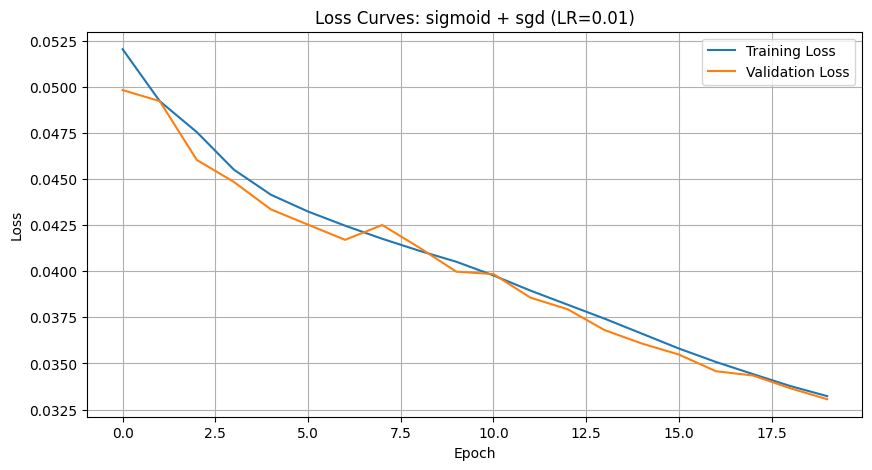

----------------------------------------



Training with: Activation=sigmoid, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0406, Val Loss: 0.0399
Epoch 20/30, Train Loss: 0.0332, Val Loss: 0.0333
Epoch 30/30, Train Loss: 0.0290, Val Loss: 0.0292


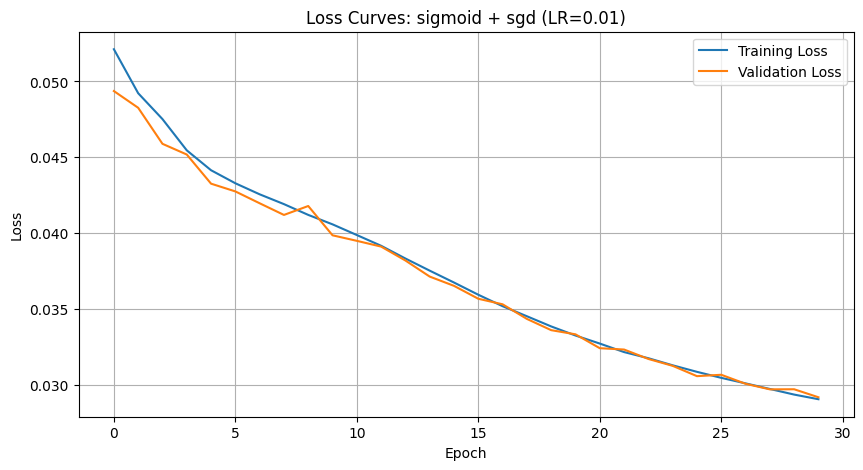

----------------------------------------



Training with: Activation=sigmoid, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0422, Val Loss: 0.0433
Epoch 20/20, Train Loss: 0.0369, Val Loss: 0.0369


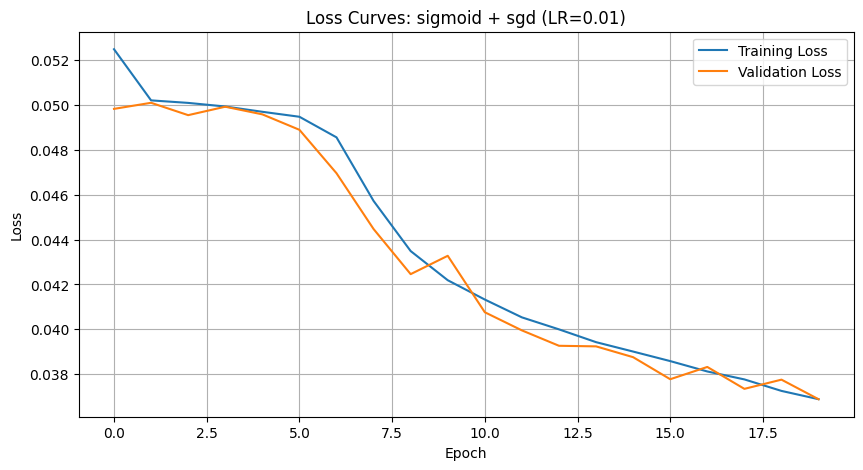

----------------------------------------



Training with: Activation=sigmoid, Optimizer=sgd, LR=0.01, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0420, Val Loss: 0.0411
Epoch 20/30, Train Loss: 0.0370, Val Loss: 0.0365
Epoch 30/30, Train Loss: 0.0318, Val Loss: 0.0330


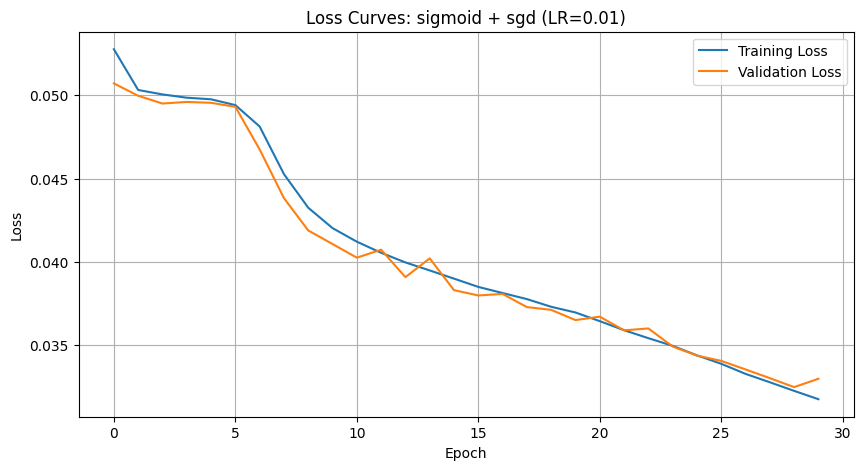

----------------------------------------



Training with: Activation=sigmoid, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0488, Val Loss: 0.0487
Epoch 20/20, Train Loss: 0.0477, Val Loss: 0.0476


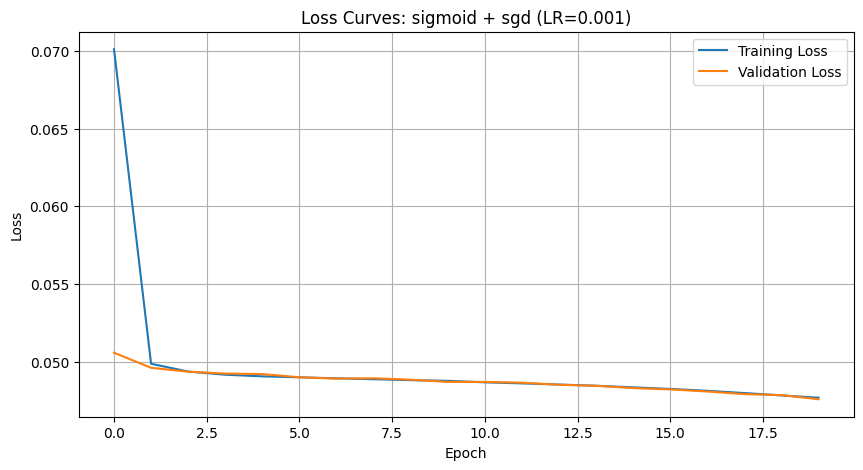

----------------------------------------



Training with: Activation=sigmoid, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0487, Val Loss: 0.0487
Epoch 20/30, Train Loss: 0.0475, Val Loss: 0.0474
Epoch 30/30, Train Loss: 0.0455, Val Loss: 0.0453


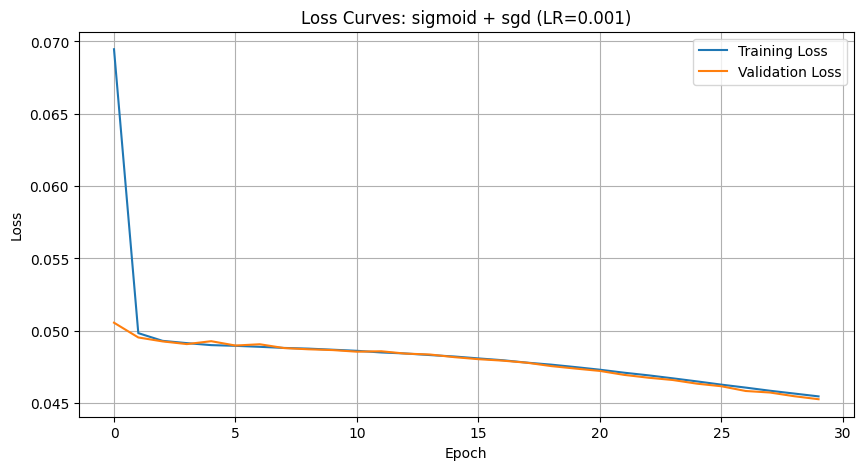

----------------------------------------



Training with: Activation=sigmoid, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/20, Train Loss: 0.0491, Val Loss: 0.0492
Epoch 20/20, Train Loss: 0.0491, Val Loss: 0.0492


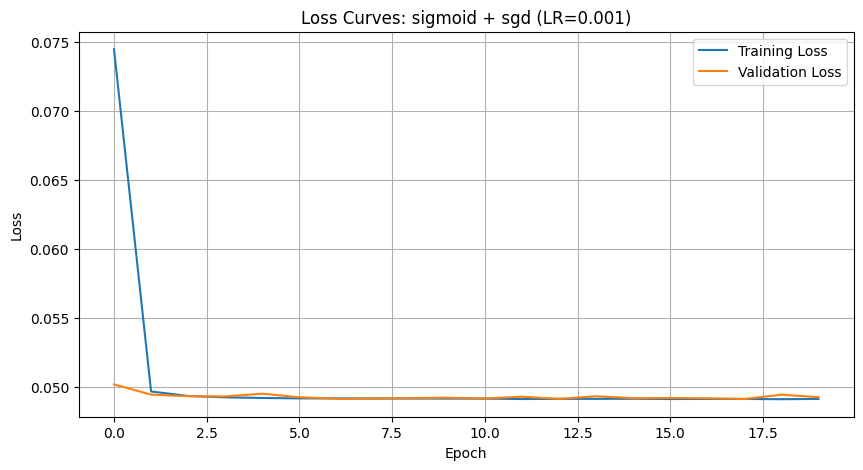

----------------------------------------



Training with: Activation=sigmoid, Optimizer=sgd, LR=0.001, Architecture=[5000, 128, 64, 90], Batch Size=32
Epoch 10/30, Train Loss: 0.0491, Val Loss: 0.0492
Epoch 20/30, Train Loss: 0.0491, Val Loss: 0.0491
Epoch 30/30, Train Loss: 0.0491, Val Loss: 0.0491


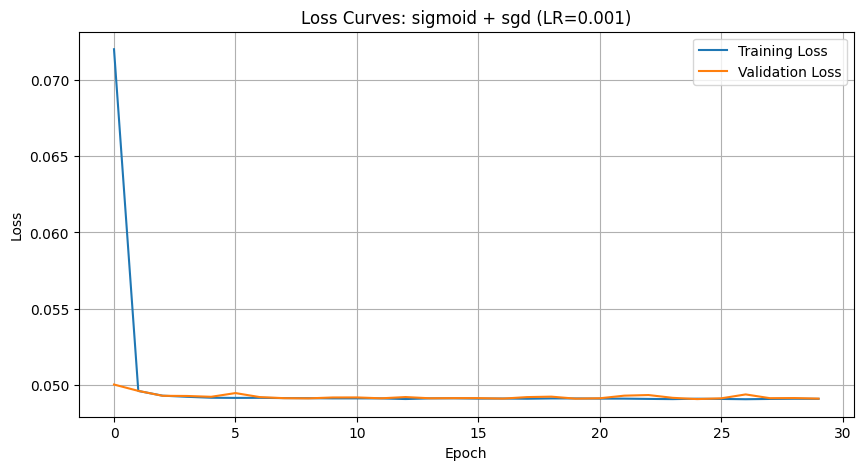

----------------------------------------




In [5]:
results = run_experiments(X_train_cp, y_train_cp, X_val_cp, y_val_cp, X_test_cp, y_test_cp, input_size, output_size)

In [ ]:
def display_results(results):
    print("\n======= RESULTS =======")
    
    # Sort results by test F1 score
    sorted_results = sorted(results, key=lambda x: x['test_metrics']['F1 Score'], reverse=True)
    
    for i, result in enumerate(sorted_results):
        if 'config' in result:  
            config = result['config']
            print(f"\nRank {i+1}: {config['activation']} + {config['optimizer']} (LR={config['lr']})")
        else:  
            print(f"\nRank {i+1}: {result['activation']} + {result['optimizer']} (LR={result['learning_rate']})")
        
        print(f"Architecture: {result['architecture'] if 'architecture' in result else result['config']['arch']}")
        print(f"Batch Size: {result['batch_size'] if 'batch_size' in result else result['config']['batch_size']}")
        print(f"Training Time: {result['training_time']:.2f} seconds")
        
        print("\nTest Metrics:")
        for metric, value in result['test_metrics'].items():
            print(f"  {metric}: {value:.4f}")
    
    # Identify best configuration
    best_result = sorted_results[0]
    print("\n===== BEST CONFIGURATION =====")
    if 'config' in best_result: 
        best_config = best_result['config']
        print(f"Activation: {best_config['activation']}")
        print(f"Optimizer: {best_config['optimizer']}")
        print(f"Learning Rate: {best_config['lr']}")
        print(f"Architecture: {best_config['arch']}")
        print(f"Batch Size: {best_config['batch_size']}")
    else: 
        print(f"Activation: {best_result['activation']}")
        print(f"Optimizer: {best_result['optimizer']}")
        print(f"Learning Rate: {best_result['learning_rate']}")
        print(f"Architecture: {best_result['architecture']}")
        print(f"Batch Size: {best_result['batch_size']}")
    
    print("\nBest Test Metrics:")
    for metric, value in best_result['test_metrics'].items():
        print(f"  {metric}: {value:.4f}")

In [ ]:
display_results(results)
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)


======= RESULTS =======

Rank 1: tanh + mini_batch (LR=0.01)
Architecture: [5000, 128, 64, 90]
Batch Size: 32
Training Time: 12.54 seconds

Test Metrics:
  Hamming Loss: 0.0039
  Accuracy: 0.7976
  Precision: 0.8858
  Recall: 0.8245
  F1 Score: 0.8541

Rank 2: relu + sgd (LR=0.01)
Architecture: [5000, 128, 64, 90]
Batch Size: 32
Training Time: 350.52 seconds

Test Metrics:
  Hamming Loss: 0.0043
  Accuracy: 0.7827
  Precision: 0.8517
  Recall: 0.8360
  F1 Score: 0.8438

Rank 3: tanh + mini_batch (LR=0.01)
Architecture: [5000, 128, 64, 90]
Batch Size: 32
Training Time: 8.32 seconds

Test Metrics:
  Hamming Loss: 0.0042
  Accuracy: 0.7764
  Precision: 0.8771
  Recall: 0.8080
  F1 Score: 0.8411

Rank 4: tanh + sgd (LR=0.01)
Architecture: [5000, 128, 64, 90]
Batch Size: 32
Training Time: 327.37 seconds

Test Metrics:
  Hamming Loss: 0.0045
  Accuracy: 0.7744
  Precision: 0.8412
  Recall: 0.8317
  F1 Score: 0.8364

Rank 5: tanh + sgd (LR=0.01)
Architecture: [5000, 128, 64, 90]
Batch Size: 


Best model based on Hamming Loss:
  Activation: tanh
  Optimizer: mini_batch
  Learning Rate: 0.01
  Architecture: [5000, 128, 64, 90]
  Batch Size: 32
  Test Hamming Loss: 0.0039


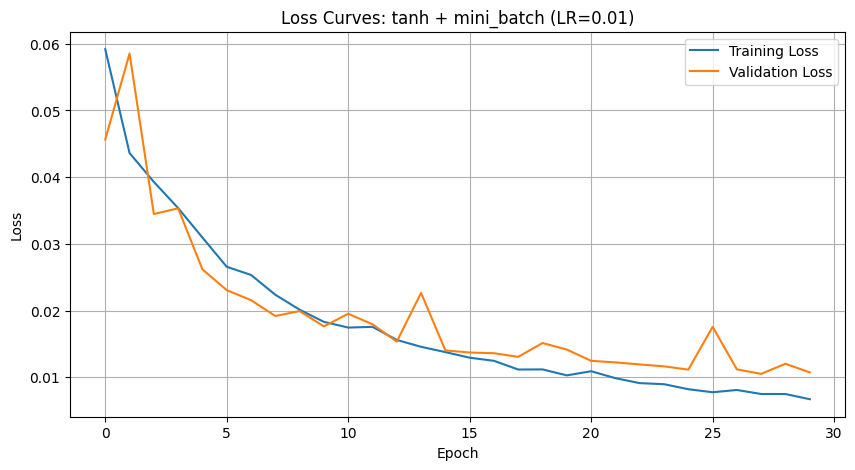


Best model based on Accuracy:
  Activation: tanh
  Optimizer: mini_batch
  Learning Rate: 0.01
  Architecture: [5000, 128, 64, 90]
  Batch Size: 32
  Test Accuracy: 0.7976


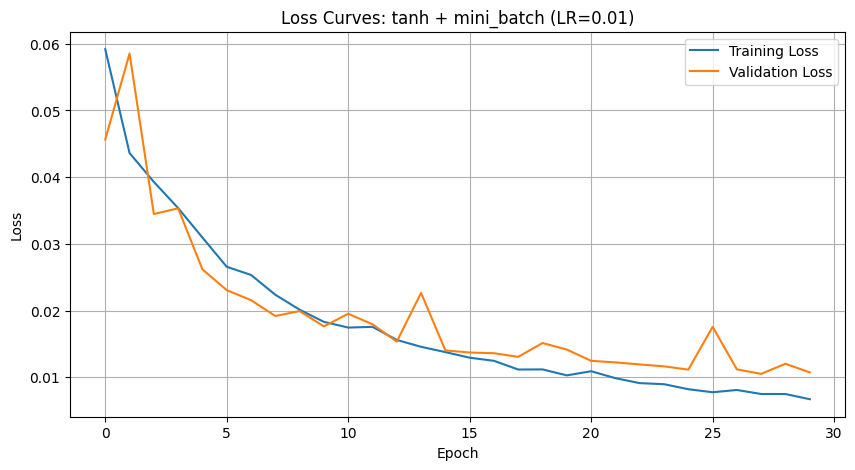

In [ ]:
# Find the best model based on Hamming Loss
best_result = min(results, key=lambda x: x['test_metrics']['Hamming Loss'])
print("\nBest model based on Hamming Loss:")
print(f"  Activation: {best_result['activation']}")
print(f"  Optimizer: {best_result['optimizer']}")
print(f"  Learning Rate: {best_result['learning_rate']}")
print(f"  Architecture: {best_result['architecture']}")
print(f"  Batch Size: {best_result['batch_size']}")
print(f"  Test Hamming Loss: {best_result['test_metrics']['Hamming Loss']:.4f}")

# Plot training curves for the best model
plt.figure(figsize=(10, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(best_result['train_loss_history'], label='Training Loss')
plt.plot(best_result['val_loss_history'], label='Validation Loss')
plt.title(f'Loss Curves: {best_result["activation"]} + {best_result["optimizer"]} (LR={best_result["learning_rate"]})')
plt.legend()
plt.grid(True)
plt.show()

# Find the best model based on Accuracy
best_result = max(results, key=lambda x: x['test_metrics']['Accuracy'])
print("\nBest model based on Accuracy:")
print(f"  Activation: {best_result['activation']}")
print(f"  Optimizer: {best_result['optimizer']}")
print(f"  Learning Rate: {best_result['learning_rate']}")
print(f"  Architecture: {best_result['architecture']}")
print(f"  Batch Size: {best_result['batch_size']}")
print(f"  Test Accuracy: {best_result['test_metrics']['Accuracy']:.4f}")

# Plot training curves for the best model
plt.figure(figsize=(10, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(best_result['train_loss_history'], label='Training Loss')
plt.plot(best_result['val_loss_history'], label='Validation Loss')
plt.title(f'Loss Curves: {best_result["activation"]} + {best_result["optimizer"]} (LR={best_result["learning_rate"]})')
plt.legend()
plt.grid(True)
plt.show()
